# Implémentez un modèle de scoring

*Notebook modélisation - simulations*

L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

**Mission :**

- Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.

- Analyser les features qui contribuent le plus au modèle, d’une manière générale (feature importance globale) et au niveau d’un client (feature importance locale), afin, dans un soucis de transparence, de permettre à un chargé d’études de mieux comprendre le score attribué par le modèle.

- Mettre en production le modèle de scoring de prédiction à l’aide d’une API et réaliser une interface de test de cette API.

- Mettre en œuvre une approche globale MLOps de bout en bout, du tracking des expérimentations à l’analyse en production du data drift.
    + Dans le notebook d’entraînement des modèles, générer à l’aide de MLFlow un tracking d'expérimentations
    + Lancer l’interface web 'UI MLFlow" d'affichage des résultats du tracking
    + Réaliser avec MLFlow un stockage centralisé des modèles dans un “model registry”
    + Tester le serving MLFlow
    + Gérer le code avec le logiciel de version Git
    + Partager le code sur Github pour assurer une intégration continue
    + Utiliser Github Actions pour le déploiement continu et automatisé du code de l’API sur le cloud
    + Concevoir des tests unitaires avec Pytest (ou Unittest) et les exécuter de manière automatisée lors du build réalisé par Github Actions

## 1 - Préparer l'environnement d'expérimentation

### 1.1 - Imports

In [75]:
import mlflow
import mlflow.tracking
from mlflow.models import infer_signature

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, make_scorer, f1_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline  # Pipeline de imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler

import lightgbm
from lightgbm import LGBMClassifier

import xgboost
from xgboost import XGBClassifier

import shap
shap.initjs()

from contextlib import contextmanager
from collections import Counter
import time
import timeit

print("numpy version", np.__version__)
print("pandas version", pd.__version__)
print("matplotlib version", matplotlib.__version__)
print("seaborn version", sns.__version__)
print("mlflow version", mlflow.__version__)
print("sklearn version", sklearn.__version__)
print("lightgbm version", lightgbm.__version__)
print("xgboost version", xgboost.__version__)
print("shap version", shap.__version__)

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_rows = 200
pd.options.display.max_columns = 130

numpy version 1.26.4
pandas version 2.1.4
matplotlib version 3.8.0
seaborn version 0.13.2
mlflow version 2.20.1
sklearn version 1.6.1
lightgbm version 4.6.0
xgboost version 2.1.3
shap version 0.46.0


### 1.2 - Lancement du serveur MLFlow

Dans le terminal de Powershell Prompt d'Anaconda, lancer cette instruction :

mlflow server --host 127.0.0.1 --port 5000 --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./mlruns

Cette commande permet de :
- Stocker les métadonnées du Model Registry dans une base de données locale SQLite.
- Stocker les artefacts (modèles, fichiers) en local.

### 1.3 - Initialisation du Tracking MLFlow de test

In [3]:
import os

# Ignorer Git
os.environ['GIT_PYTHON_REFRESH'] = 'quiet'

# Vérification si la variable d'environnement est bien définie
print(os.environ.get('GIT_PYTHON_REFRESH'))

# Définir le serveur de tracking (local ou distant) - ici local
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Démarrer une nouvelle expérimentation
mlflow.set_experiment("simulation_scoring_credit_9")

quiet


<Experiment: artifact_location='file:///C:/Users/admin/mlruns/17', creation_time=1740322718731, experiment_id='17', last_update_time=1740322718731, lifecycle_stage='active', name='simulation_scoring_credit_9', tags={}>

### 1.4 - Enregistrer le modèle et ses métadonnées dans MLFlow

Créons une fonction :

In [5]:
def tracking_mlflow(tag, model, params, metrics, registered_model_name, X_train, roc_curve_path, pr_curve_path, 
                    val_auc_fic_test, optimal_threshold_test, min_business_score_test, optimal_threshold_train, min_business_score_train):
    
    # Démarrer une expérimentation dans MLflow
    with mlflow.start_run():
        try:
        
            # Log the hyperparameters
            mlflow.log_params(params)
            
            # Loguer les métriques
            for key, value in metrics.items():
                mlflow.log_metric(key, value)
            mlflow.log_metric("val_auc_fic_test", val_auc_fic_test)
            mlflow.log_metric("optimal_threshold_train", optimal_threshold_train)
            mlflow.log_metric("min_business_score_train", min_business_score_train)
            mlflow.log_metric("optimal_threshold_test", optimal_threshold_test)
            mlflow.log_metric("min_business_score_test", min_business_score_test)
            
            # Set a tag that we can use to remind ourselves what this run was for
            mlflow.set_tag(tag[0], tag[1])
        
            # Infer the model signature
            signature = infer_signature(X_train, model.predict(X_train))
            
            # Loguer le modèle
            model_info = mlflow.sklearn.log_model(
                sk_model=model,
                artifact_path="iris_model",
                signature=signature,
                input_example=X_train[:5],
                registered_model_name=registered_model_name,
            )

            # Loguer les graphiques dans MLflow
            mlflow.log_artifact(roc_curve_path)
            mlflow.log_artifact(pr_curve_path)
            
            for key, value in metrics.items():
                print(key, ":" , value)

        except Exception as e:
            print(f"❌ Erreur dans MLflow : {e}")

        finally:
            mlflow.end_run()  # Assure que la run est bien fermée
    
    print(f"Modèle enregistré en version {model_info.mlflow_version}")
    
    return model_info

def save_model_mlflow(grid_search, model_name, metrics, roc_curve_path, pr_curve_path, val_auc_fic_test, 
                      optimal_threshold_test, min_business_score_test, optimal_threshold_train, min_business_score_train):
    
    elapsed = round(timeit.default_timer() - start_time, 3)
    print("📂 Durée depuis le début : ", elapsed, " - Fin entraînement",  model_name, "...")
    
    # Meilleur modèle trouvé
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Extraction des scores
    results = grid_search.cv_results_
    best_index = grid_search.best_index_
    
    # Préparation des métriques à logger
    metrics_log = {
        "best_business_score": grid_search.best_score_,
        "mean_fit_time": round(results["mean_fit_time"][best_index], 3),
    }
    
    # Ajout des autres scores
    for metric in metrics.keys():
        metrics_log[f"mean_{metric}"] = results[f"mean_test_{metric}"][best_index]
    
    # Définition des tags MLflow
    tag = ("model_type", model_name)
    
    # Nom du modèle à enregistrer dans MLflow
    registered_model_name = model_name
    
    elapsed = round(timeit.default_timer() - start_time, 3)
    print("📂 Durée depuis le début : ", elapsed, " - Début tracking MLFlow",  model_name, "...")
    
    # Appel de la fonction tracking_mlflow
    tracking_mlflow(tag, best_model, best_params, metrics_log, registered_model_name, X_train, roc_curve_path, pr_curve_path, 
                    val_auc_fic_test, optimal_threshold_test, min_business_score_test, optimal_threshold_train, min_business_score_train)
    
    elapsed = round(timeit.default_timer() - start_time, 3)
    print("📂 Durée depuis le début : ", elapsed, " - Fin tracking MLFlow",  model_name, "...")
    
    print(f"✅ Fin traitement",  model_name)

### 1.5 - Lancement de l'UI

Pour  la visualisation et la comparaison des expérimentations, ainsi que le stockage de manière centralisée des modèles.

Cliquer sur ce lien : http://127.0.0.1:5000/

### 1.6 - Charger les données issues du feature engineering

In [7]:
df = pd.read_csv('C:/Users/admin/Documents/Projets/Projet_7/data_projet/cleaned/data.csv')

print('Training data shape: ', df.shape)
df.head()

Training data shape:  (307507, 395)


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,...,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,OCCUPATION_TYPE_nan,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,ORGANIZATION_TYPE_nan
0,100002.0,1.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,-637.0,-3648.0,-2120.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,2.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.00,0.0690,0.0833,0.0369,0.0190,0.0000,0.0252,0.0383,0.9722,0.0000,0.0690,0.0833,0.0377,0.0198,0.0000,0.0250,0.0369,0.9722,0.00,0.0690,0.0833,0.0375,0.0193,0.0000,0.0149,2.0,2.0,2.0,2.0,-1134.0,0.0,...,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,100003.0,0.0,0.0,270000.0,1293502.5,35698

In [8]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [14]:
# Missing values statistics
missing_values = missing_values_table(df)
missing_values.head(130)

Your selected dataframe has 395 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Bien. Aucune valeur manquante.

### 1.7 - Créer les fonctions communes

In [9]:
def print_result_CV_as_dataframe(grid_search, scoring):

    # Liste pour stocker les résultats
    results = []
    
    # Affichage des résultats de la validation croisée
    print("Résultats de la validation croisée :")
    
    for score_name in scoring.keys():
        for mean, std, params, mean_fit_time in zip(
            grid_search.cv_results_[f'mean_test_{score_name}'],  # Score moyen pour chaque métrique
            grid_search.cv_results_[f'std_test_{score_name}'],   # Écart-type du score
            grid_search.cv_results_['params'],                   # Valeurs des hyperparamètres
            grid_search.cv_results_['mean_fit_time']             # Temps moyen d'entraînement
        ):
            # Ajout des résultats sous forme de dictionnaire
            results.append({
                "score_name": score_name,
                "mean_score": mean,
                "std_score": std,
                "params": params,
                "mean_fit_time": mean_fit_time
            })

    # Transformation en DataFrame
    df_results = pd.DataFrame(results)

    # Convertir 'params' en string pour affichage correct
    df_results['params'] = df_results['params'].apply(str)

    # Transformation avec pivot pour structurer les données
    df_results = df_results.pivot(
        index='params',                        # Les paramètres deviennent l'index
        columns='score_name',                   # Les métriques deviennent des colonnes
        values=['mean_score', 'mean_fit_time']  # Les valeurs à afficher
    ).reset_index()

    # Aplatir les colonnes multi-indexées
    df_results.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_results.columns.values]

    # Identifier la meilleure métrique de tri (prendre la première de `scoring`)
    main_metric = list(scoring.keys())[0]  # Prend la première métrique comme référence
    main_metric_col = f"mean_score_{main_metric}"

    # Trier le DataFrame selon cette métrique (du plus grand au plus petit)
    df_results.sort_values(by=main_metric_col, ascending=False, inplace=True)

    # Suppression des colonnes superflues
    fit_time_columns = [col for col in df_results.columns if "mean_fit_time_" in col and col != "mean_fit_time"]
    df_results.drop(columns=fit_time_columns, inplace=True)

    # Réinitialisation de l'index
    df_results = df_results.reset_index(drop=True)

    return df_results

# fonction basée sur le fichier train complet
def print_ROC_curve(best_model, X_train, y_train, X_test, y_test):

    # Prédire les probabilités pour la classe positive
    y_scores_train = best_model.predict_proba(X_train)[:, 1]
    y_scores_test = best_model.predict_proba(X_test)[:, 1]

    # Calculer la courbe ROC
    fpr_train, tpr_train, _ = roc_curve(y_train, y_scores_train)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_scores_test)

    # Calculer l'AUC
    auc_train = auc(fpr_train, tpr_train)
    auc_test = auc(fpr_test, tpr_test)

    # Tracer les courbes ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC (AUC = {auc_train:.2f})')
    plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC (AUC = {auc_test:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Ligne de référence
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Train vs Test")
    plt.legend(loc="lower right")

    # Retourner le plt pour l'enregistrement dans MLFlow
    return plt

# fonction basée sur les valeurs de la validation croisée
def print_ROC_curve_cv(best_model, X_train, y_train, X_test, y_test, cv=5):
    
    # Validation croisée avec prédiction des probabilités sur chaque fold
    cv_strategy = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    y_scores_cv = cross_val_predict(best_model, X_train, y_train, cv=cv_strategy, method="predict_proba")[:, 1]

    # Prédire les probabilités pour le fichier test
    y_scores_test = best_model.predict_proba(X_test)[:, 1]

    # Calculer les courbes ROC
    fpr_cv, tpr_cv, _ = roc_curve(y_train, y_scores_cv)  # Validation croisée
    fpr_test, tpr_test, _ = roc_curve(y_test, y_scores_test)

    # Calculer les AUC
    auc_cv = auc(fpr_cv, tpr_cv)
    auc_test = auc(fpr_test, tpr_test)

    # Tracer les courbes ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_cv, tpr_cv, color='green', lw=2, label=f'CV ROC (AUC = {auc_cv:.2f})')
    plt.plot(fpr_test, tpr_test, color='blue', lw=2, label=f'Test ROC (AUC = {auc_test:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Ligne de référence

    # Mise en forme
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Validation (CV) vs Test")
    plt.legend(loc="lower right")

    return plt


def print_PR_curve(best_model, X_train, y_train, X_test, y_test):

    # Prédire les probabilités pour la classe positive
    y_scores_train = best_model.predict_proba(X_train)[:, 1]
    y_scores_test = best_model.predict_proba(X_test)[:, 1]

    # Calcul des courbes PR
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_scores_train)
    precision_test, recall_test, _ = precision_recall_curve(y_test, y_scores_test)

    # Calcul des AUC PR
    auc_pr_train = auc(recall_train, precision_train)
    auc_pr_test = auc(recall_test, precision_test)

    # Tracer les courbes Precision-Recall
    plt.figure(figsize=(8, 6))
    plt.plot(recall_train, precision_train, color='blue', lw=2, label=f'Train PR (AUC = {auc_pr_train:.2f})')
    plt.plot(recall_test, precision_test, color='red', lw=2, label=f'Test PR (AUC = {auc_pr_test:.2f})')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve - Train vs Test")
    plt.legend(loc="lower left")
    plt.grid()

    # Retourner le plt pour enregistrement (MLFlow ou autre)
    return plt

def plot_histogram_with_threshold(y_true, y_pred_proba, threshold):
    """
    Trace un histogramme des scores de prédiction pour les classes 0 et 1,
    avec une ligne verticale indiquant le seuil de décision.
    """
    # Séparer les prédictions en fonction des classes réelles
    scores_class_0 = y_pred_proba[y_true == 0]  # Scores pour la classe 0 (prêts accordés)
    scores_class_1 = y_pred_proba[y_true == 1]  # Scores pour la classe 1 (prêts refusés)

    # Tracer les histogrammes
    plt.figure(figsize=(8, 6))
    plt.hist(scores_class_0, bins=50, alpha=0.6, label="Classe 0 (prêts accordés)", color="blue")
    plt.hist(scores_class_1, bins=50, alpha=0.6, label="Classe 1 (prêts refusés)", color="red")

    # Ajouter la ligne verticale pour le seuil optimal
    plt.axvline(threshold, color="black", linestyle="--", label=f"Seuil optimal = {threshold:.4f}")

    # Labels et titre
    plt.xlabel("Probabilité prédite")
    plt.ylabel("Densité")
    plt.title("Distribution des probabilités de prédiction par classe")
    plt.legend()
    plt.show()

def plot_bar_histogram(y_true, y_pred_proba, threshold):
    """
    Trace un histogramme avec seulement deux barres :
    - Une pour la classe 0 (prêts accordés)
    - Une pour la classe 1 (prêts refusés)
    """
    # Calculer la moyenne des probabilités prédites pour chaque classe
    mean_score_0 = np.mean(y_pred_proba[y_true == 0])  # Moyenne des scores pour la classe 0
    mean_score_1 = np.mean(y_pred_proba[y_true == 1])  # Moyenne des scores pour la classe 1

    # Création du graphique
    plt.figure(figsize=(6, 5))
    plt.bar(["Classe 0 (prêts accordés)", "Classe 1 (prêts refusés)"], [mean_score_0, mean_score_1], color=["blue", "red"], alpha=0.7)

    # Ajouter une ligne pour le seuil optimal
    plt.axhline(y=threshold, color="black", linestyle="--", label=f"Seuil optimal = {threshold:.4f}")

    # Labels et titre
    plt.ylabel("Probabilité moyenne prédite")
    plt.title("Moyenne des scores prédits pour chaque classe")
    plt.legend()
    plt.show()

def plot_auc_folds(best_model, X, y, cv):
    auc_scores = []  # Stocker les AUC pour chaque fold
    fold_numbers = np.arange(1, cv.get_n_splits() + 1)  # Liste des folds (1, 2, 3, ...)

    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Prédictions des probabilités pour la classe positive (1)
        y_scores = best_model.predict_proba(X_test)[:, 1]

        # Calcul de l'AUC
        auc = roc_auc_score(y_test, y_scores)
        auc_scores.append(auc)

    # Tracer l'évolution de l'AUC
    plt.figure(figsize=(8, 5))
    plt.plot(fold_numbers, auc_scores, marker='o', linestyle='-', color='b', label='AUC par fold')
    plt.axhline(y=np.mean(auc_scores), color='r', linestyle='--', label=f'Moyenne AUC: {np.mean(auc_scores):.3f}')
    plt.xlabel("Numéro du Fold")
    plt.ylabel("AUC Score")
    plt.title("Variation de l'AUC par Fold")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_roc_folds(best_model, X, y, cv):
    """
    Trace les courbes ROC des différents splits (folds) de la cross-validation.
    
    Parameters:
        - best_model: best_model du GridSearchCV déjà entraîné.
        - X: Features utilisées pour la validation croisée.
        - y: Labels réels.
        - cv: Stratégie de validation croisée (ex: StratifiedKFold).
    """
    mean_fpr = np.linspace(0, 1, 100)  # Points communs pour interpoler les courbes ROC
    tprs = []
    aucs = []

    plt.figure(figsize=(8, 6))
    
    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Prédictions des probabilités pour la classe positive (1)
        y_scores = best_model.predict_proba(X_test)[:, 1]

        # Calculer la courbe ROC
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)

        # Sauvegarder les TPR interpolés pour la moyenne
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        aucs.append(roc_auc)

        # Tracer la courbe ROC du fold
        plt.plot(fpr, tpr, alpha=0.3, label=f"Fold {fold_idx+1} (AUC = {roc_auc:.2f})")

    # Tracer la moyenne des courbes ROC
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    plt.plot(mean_fpr, mean_tpr, color="blue", label=f"Moyenne ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})", lw=2)

    # Ligne diagonale
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

    # Paramètres du graphe
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Courbe ROC par Fold (Cross-validation)")
    plt.legend()
    plt.show()

## 2 - Créer un score métier pour l'entraînement des modèles

### 2.1 - Créer le score métier et le score pour le seuil

In [10]:
# Calculer le coût
def calculate_errors_cost(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    return 10 * fn + fp

# On transforme le score en négatif pour que GridSearchCV le minimise
neg_business_scorer = make_scorer(calculate_errors_cost, greater_is_better=False)

# Scorer pour renvoyer le seuil utilisé
#def get_threshold_score(y_true, y_proba, threshold=0.5):
#    y_pred = (y_proba >= threshold).astype(int)
#    return threshold  # Retourne le seuil utilisé

#threshold_scorer = make_scorer(get_threshold_score, needs_proba=True)

Test de la fonction : 

In [21]:
y_test_sample = [0, 1, 1, 0, 1, 0, 0, 1, 1, 0]
y_pred_sample = [0, 0, 1, 0, 1, 0, 1, 1, 1, 0]

print("Résultat de calculate_errors_cost:", calculate_errors_cost(y_test_sample, y_pred_sample))

Résultat de calculate_errors_cost: 11


### 2.2 - Créer une fonction pour trouver le seuil optimal

Le seuil optimal est la valeur à partir de laquelle on décide si un client doit obtenir ou non un crédit, basé sur la probabilité prédite par le modèle. Le but est de trouver un seuil qui minimise le coût métier, c'est-à-dire le coût total des erreurs de prédiction en tenant compte des faux positifs (FP) et des faux négatifs (FN), où les faux négatifs sont 10 fois plus coûteux.

Le seuil optimal est celui qui donne le coût total le plus bas.

In [11]:
def find_optimal_threshold_business(y_true, y_scores, calculate_errors_cost):
    # Calcul de la courbe PR pour obtenir les seuils possibles
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

    # Ajouter le seuil 0.5 au cas où il ne serait pas dans la liste
    thresholds = np.append(thresholds, 0.5)

    # Calculer `business_score` pour chaque seuil
    business_scores = []
    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)  # Binarisation selon le seuil
        score = calculate_errors_cost(y_true, y_pred)
        business_scores.append(score)

    # Trouver le seuil qui minimise le `business_score`
    optimal_idx = np.argmin(business_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    return optimal_threshold, business_scores[optimal_idx]

## 3 - Simuler et comparer plusieurs modèles avec undersampling

Pour corriger le déséquilibre entre le nombre de bons et de moins bons clients, 3 solutions peuvent être utilisées :

- SMOTE : qui permet de génèrer des exemples synthétiques pour la classe minoritaire, en créant de nouvelles instances en interpolant entre les exemples existants de la classe minoritaire.

  - j'ai commencé avec cette méthode, mais les temps de traitement étaient trop long, et faisait planter mon PC à cause des 300 000 lignes qu'il générère pour le réquilibrage. 


- Ou par ajustement des poids des classes par paramétrage des modèles de type "class_weight"
  
  - Logistic Regression avec class_weight="balanced"
  
  - Random Forest avec class_weight="balanced"
  
  - Decision Tree avec class_weight="balanced"
  
  - XGBoost avec scale_pos_weight
  
  - LightGBM avec is_unbalance=True ou scale_pos_weight

- Ou par Undersampling (sous-échantillonage) : réduire la taille de la classe majoritaire pour équilibrer les proportions. L'avantage c'est qu'elle réduit la taille du dataset, ce qui permet un gain de rapidité pour des premières simulation. Je vais donc commencer les simulations avec cette méthodes, pour faire une 1ere sélection des modèles, et ensuite je travaillerais avec SMOTE (oversampling) pour l'affinage.

### 3.1 - Préparer le dataset avec undersampling

Distribution après sous-échantillonnage : Counter({0.0: 24825, 1.0: 24825})
taille X_train :  (39720, 394)
taille y_train :  (39720,)
taille X_test :  (9930, 394)
taille y_test :  (9930,)


<Axes: ylabel='Frequency'>

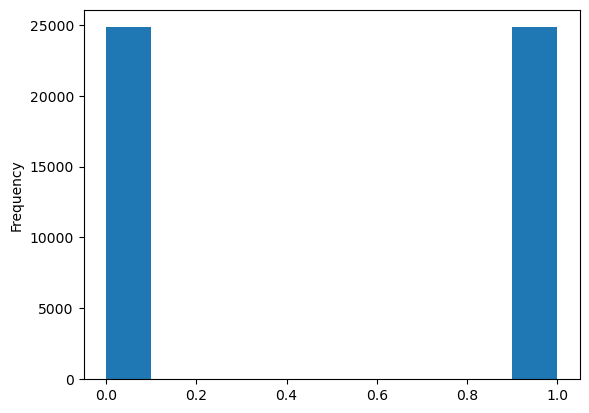

In [17]:
# Définition des features et de la target
X = df.drop(columns=["TARGET"])  # Features
y = df["TARGET"]  # Variable cible

# sous-échantillonage
X_resampled, y_resampled = RandomUnderSampler().fit_resample(X, y)
print(f"Distribution après sous-échantillonnage : {Counter(y_resampled)}")

# Centrage et réduction des données
X_scale = StandardScaler().fit_transform(X_resampled)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_scale, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

print("taille X_train : ", X_train.shape)
print("taille y_train : ", y_train.shape)
print("taille X_test : ", X_test.shape)
print("taille y_test : ", y_test.shape)

y_resampled.plot.hist()

In [19]:
# Scorer personnalisé pour calculer l'AUC (besoin des probabilités)
#def auc_scorer(y_true, y_proba):
#    return roc_auc_score(y_true, y_proba)

# `needs_proba=True` pour utiliser `predict_proba`
#auc_scorer = make_scorer(auc_scorer, needs_proba=True)

# Scorers personnalisés
metrics = {
    "business_score": neg_business_scorer,
    "accuracy": make_scorer(accuracy_score),  # Accuracy classique,
    "AUC": "roc_auc",
    "f1_macro": make_scorer(f1_score, average="macro"),  # F1-score macro
    "precision": make_scorer(precision_score, average="macro"),  # Précision macro
    "recall": make_scorer(recall_score, average="macro"),  # Rappel macro
}

### 3.2 - Simuler avec DumyClassifier (Baseline)

In [29]:
print("📂 Lancement du traitement DummyClassifier...")
start_time = timeit.default_timer()

# Définition des paramètres à tester
param_grid = {
    'strategy': ['most_frequent']
}

# Initialisation du modèle
dummy_clf = DummyClassifier()

# GridSearchCV avec plusieurs scores
grid_search = GridSearchCV(dummy_clf, param_grid, scoring=metrics, refit="business_score", cv=5, n_jobs=1, verbose=1)

# Exécution de la recherche
grid_search.fit(X_train, y_train)

# Sélectionner le meilleur modèle de GridSearchCV
best_model = grid_search.best_estimator_

# Tracer la courbe ROC Curve
plt = print_ROC_curve(best_model, X_train, y_train, X_test, y_test)

# Sauvegarder le graphique dans un fichier
roc_curve_path = "roc_curve.png"
plt.savefig(roc_curve_path)
plt.close()

# Tracer la courbe PR Curve
plt = print_ROC_curve_cv(best_model, X_train, y_train, X_test, y_test, cv=5)

# Sauvegarder le graphique dans un fichier
pr_curve_path = "pr_curve.png"
plt.savefig(pr_curve_path)
plt.close()

# Faire des prédictions de probabilité sur l'ensemble de test
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positive

# Faire des prédictions de probabilité sur l'ensemble de train
y_pred_proba_train = best_model.predict_proba(X_train)[:, 1]  # Probabilités pour la classe positive

# Calculer l'AUC
auc_score_test = roc_auc_score(y_test, y_pred_proba_test)

# Calculer le seuil optimal test et train
optimal_threshold_train, min_business_score_train = find_optimal_threshold_business(y_train, y_pred_proba_train, calculate_errors_cost)
print("📂", f"Seuil optimal train: {optimal_threshold_train:.4f}, Business Score minimal : {min_business_score_train:.4f}")
optimal_threshold_test, min_business_score_test = find_optimal_threshold_business(y_test, y_pred_proba_test, calculate_errors_cost)
print("📂", f"Seuil optimal test: {optimal_threshold_test:.4f}, Business Score minimal : {min_business_score_test:.4f}")

# Sauvegarder les informations dans MLFow
save_model_mlflow(grid_search, "DummyClassifier_gridSearchCV", metrics, roc_curve_path, pr_curve_path, auc_score_test, optimal_threshold_test, min_business_score_test,
                 optimal_threshold_train, min_business_score_train)

# Supprimer le fichier temporaire
os.remove(roc_curve_path)
os.remove(pr_curve_path)

📂 Lancement du traitement DummyClassifier...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
📂 Seuil optimal train: 0.0000, Business Score minimal : 19860.0000
📂 Seuil optimal test: 0.0000, Business Score minimal : 4965.0000
📂 Durée depuis le début :  2.882  - Fin entraînement DummyClassifier_gridSearchCV ...
📂 Durée depuis le début :  2.882  - Début tracking MLFlow DummyClassifier_gridSearchCV ...


Registered model 'DummyClassifier_gridSearchCV' already exists. Creating a new version of this model...
2025/02/23 15:59:36 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DummyClassifier_gridSearchCV, version 3


best_business_score : -39720.0
mean_fit_time : 0.142
mean_business_score : -39720.0
mean_accuracy : 0.5
mean_AUC : 0.5
mean_f1_macro : 0.3333333333333333
mean_precision : 0.25
mean_recall : 0.5
🏃 View run fearless-stag-893 at: http://127.0.0.1:5000/#/experiments/17/runs/ee1d9d6f3fc84f818379448405ff02bd
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/17
Modèle enregistré en version 2.20.1
📂 Durée depuis le début :  22.021  - Fin tracking MLFlow DummyClassifier_gridSearchCV ...
✅ Fin traitement DummyClassifier_gridSearchCV


Created version '3' of model 'DummyClassifier_gridSearchCV'.


**Affichons la courbe ROC AUC**

Text(0, 0.5, 'True Positive Rate')

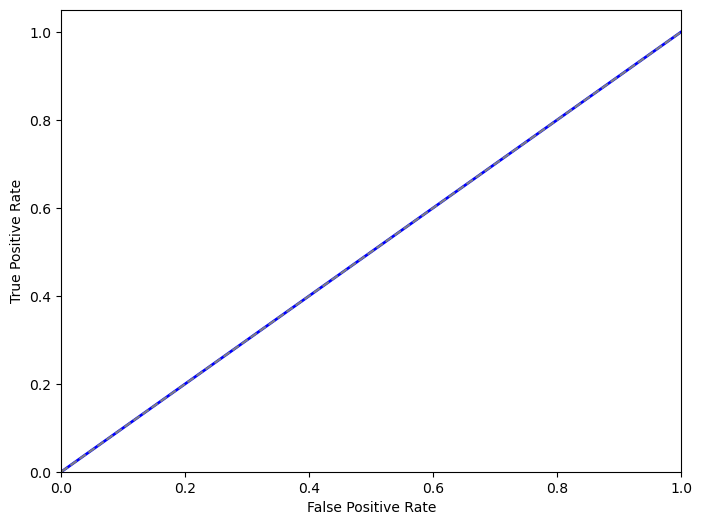

In [31]:
# 2. Prédire les probabilités sur le jeu de test
y_scores = best_model.predict_proba(X_test)[:, 1]  # Probabilité pour la classe positive

# 3. Calculer la courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# 4. Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Ligne de référence
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

La courbe ROC et la diagonale se confondent. C'est normal car le DummyClassifier avec le paramètre "most_frequent" avait une chance sur 2 de se tromper. Et comme les données en entrées sont équilibrés, on observe ce comportement.

<module 'matplotlib.pyplot' from 'C:\\Users\\admin\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

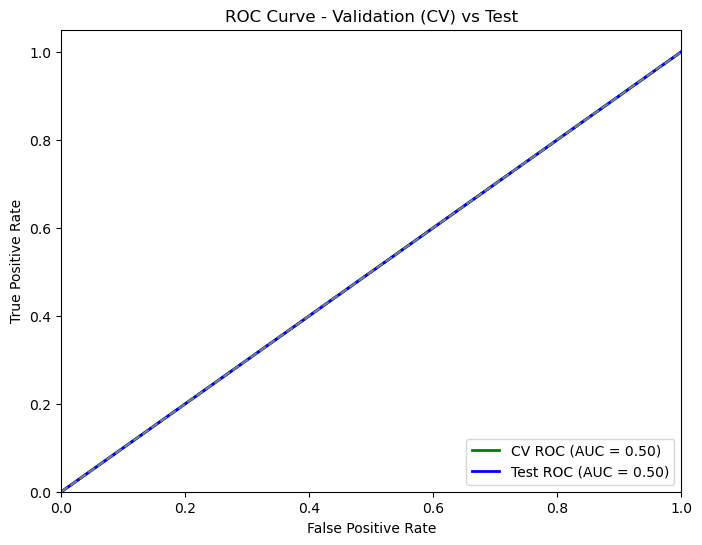

In [33]:
print_ROC_curve_cv(best_model, X_train, y_train, X_test, y_test, cv=5)

**Affichons la courbe PR**

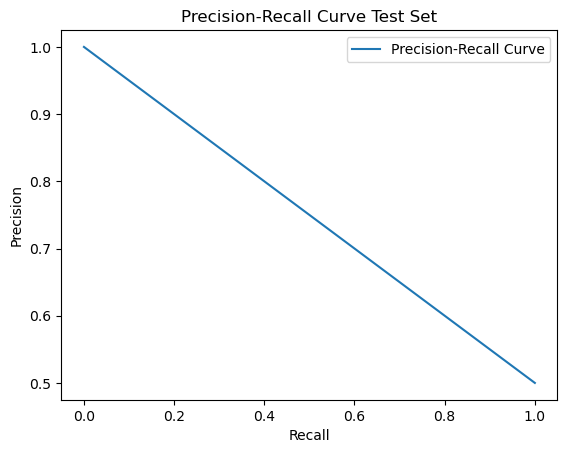

In [35]:
y_scores_test = best_model.predict_proba(X_test)[:, 1]

precision_test, recall_test, thresholds_test = precision_recall_curve(
    y_test, y_scores_test
)

plt.plot(recall_test, precision_test, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Test Set")
plt.legend()
plt.show()

auc_test = auc(recall_test, precision_test)

### 3.3 - Simuler avec LogisticRegression

In [37]:
print("📂 Lancement du traitement LogisticRegression...")
start_time = timeit.default_timer()

# Initialisation du modèle
base_model = LogisticRegression(random_state=42)  # Utilisation d'un solver adapté

# Paramètres à tester dans GridSearchCV
param_grid = {
    "C": [0.01, 1, 100],  # Régularisation
    "penalty": ["l1", "l2"],
    "solver": ["liblinear"]
}

grid_search = GridSearchCV(
    base_model,
    param_grid=param_grid,
    scoring=metrics,
    refit="business_score",
    cv=5,
    n_jobs=-1,
    return_train_score=True
)

grid_search.fit(X_train, y_train)


# Sélectionner le meilleur modèle de GridSearchCV
best_model = grid_search.best_estimator_

# Tracer la courbe ROC Curve
plt = print_ROC_curve(best_model, X_train, y_train, X_test, y_test)

# Sauvegarder le graphique dans un fichier
roc_curve_path = "roc_curve.png"
plt.savefig(roc_curve_path)
plt.close()

# Tracer la courbe PR Curve
plt = print_ROC_curve_cv(best_model, X_train, y_train, X_test, y_test, cv=5)

# Sauvegarder le graphique dans un fichier
pr_curve_path = "pr_curve.png"
plt.savefig(pr_curve_path)
plt.close()

# Faire des prédictions de probabilité sur l'ensemble de test
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positive

# Faire des prédictions de probabilité sur l'ensemble de train
y_pred_proba_train = best_model.predict_proba(X_train)[:, 1]  # Probabilités pour la classe positive

# Calculer l'AUC
auc_score_test = roc_auc_score(y_test, y_pred_proba_test)

# Calculer le seuil optimal test et train
optimal_threshold_train, min_business_score_train = find_optimal_threshold_business(y_train, y_pred_proba_train, calculate_errors_cost)
print("📂", f"Seuil optimal train: {optimal_threshold_train:.4f}, Business Score minimal : {min_business_score_train:.4f}")

optimal_threshold_test, min_business_score_test = find_optimal_threshold_business(y_test, y_pred_proba_test, calculate_errors_cost)
print("📂", f"Seuil optimal test: {optimal_threshold_test:.4f}, Business Score minimal : {min_business_score_test:.4f}")

save_model_mlflow(grid_search, "LogisticRegression_gridSearchCV", metrics, roc_curve_path, pr_curve_path, auc_score_test, optimal_threshold_test, min_business_score_test,
                 optimal_threshold_train, min_business_score_train)

# Supprimer le fichier temporaire
os.remove(roc_curve_path)
os.remove(pr_curve_path)

📂 Lancement du traitement LogisticRegression...
📂 Seuil optimal train: 0.0445, Business Score minimal : 19754.0000
📂 Seuil optimal test: 0.0416, Business Score minimal : 4935.0000
📂 Durée depuis le début :  5260.264  - Fin entraînement LogisticRegression_gridSearchCV ...
📂 Durée depuis le début :  5260.264  - Début tracking MLFlow LogisticRegression_gridSearchCV ...


Registered model 'LogisticRegression_gridSearchCV' already exists. Creating a new version of this model...
2025/02/23 17:27:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegression_gridSearchCV, version 23


best_business_score : -13282.4
mean_fit_time : 198.711
mean_business_score : -13282.4
mean_accuracy : 0.696122860020141
mean_AUC : 0.7625634603351354
mean_f1_macro : 0.6961182628440326
mean_precision : 0.6961347328546077
mean_recall : 0.696122860020141
🏃 View run sedate-roo-810 at: http://127.0.0.1:5000/#/experiments/17/runs/c6ffd7bb0f4a480ba1debc5da97d3d60
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/17
Modèle enregistré en version 2.20.1
📂 Durée depuis le début :  5271.876  - Fin tracking MLFlow LogisticRegression_gridSearchCV ...
✅ Fin traitement LogisticRegression_gridSearchCV


Created version '23' of model 'LogisticRegression_gridSearchCV'.


In [38]:
print_result_CV_as_dataframe(grid_search, metrics) 

Résultats de la validation croisée :


,params_,mean_score_AUC,mean_score_accuracy,mean_score_business_score,mean_score_f1_macro,mean_score_precision,mean_score_recall
0,"{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}",0.762563,0.696123,-13282.4,0.696118,0.696135,0.696123
1,"{'C': 100, 'penalty': 'l2', 'solver': 'libline...",0.762939,0.695972,-13298.0,0.695969,0.695980,0.695972
2,"{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}",0.762533,0.695947,-13298.2,0.695942,0.695959,0.695947
3,"{'C': 100, 'penalty': 'l1', 'solver': 'libline...",0.762687,0.695871,-13300.6,0.695867,0.695881,0.695871
4,"{'C': 0.01, 'penalty': 'l2', 'solver': 'liblin...",0.761430,0.693882,-13377.6,0.693878,0.693892,0.693882
5,"{'C': 0.01, 'penalty': 'l1', 'solver': 'liblin...",0.757803,0.692095,-13642.0,0.692084,0.692122,0.692095


**Traçons l'histogramme des probabilités:**

Un bon moyen d'analyser les performances d'un modèle de classification consiste à tracer l'histogramme des probabilités des prédictions.

<Axes: ylabel='Count'>

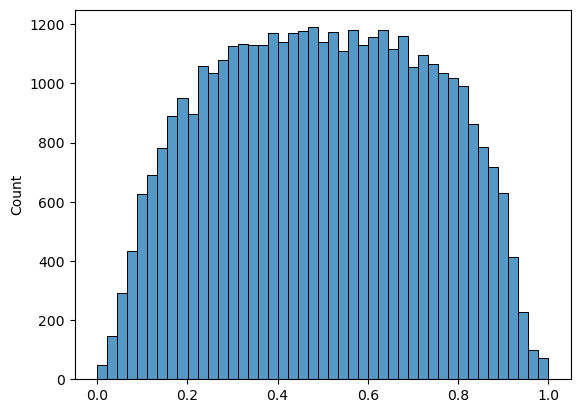

In [40]:
# Récupérer les probabilités prédites sur un jeu d'entraînement
y_proba_train = best_model.predict_proba(X_train)[:,1]

# Afficher l'histogramme
sns.histplot(y_proba_train)

<Axes: ylabel='Count'>

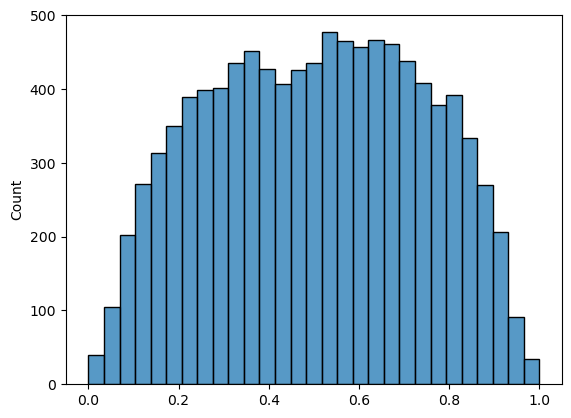

In [41]:
# Récupérer les probabilités prédites sur un jeu de test
y_proba_test = best_model.predict_proba(X_test)[:,1]

# Afficher l'histogramme
sns.histplot(y_proba_test)

On observe que les probabilités de prédictions ne sont pas clairement espacés. La distribution suit la loi normal. C'est clairement l'histogramme d'un modèle incertain.

**Affichons la courbe ROC**

<module 'matplotlib.pyplot' from 'C:\\Users\\admin\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

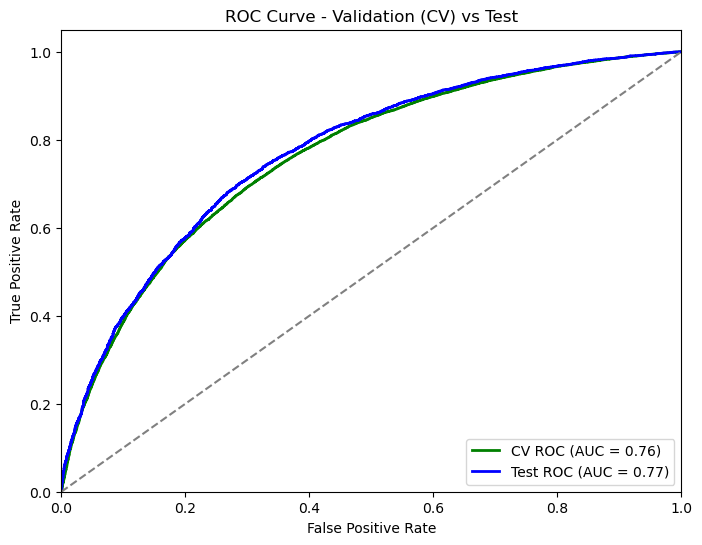

In [43]:
print_ROC_curve_cv(best_model, X_train, y_train, X_test, y_test, cv=5)

**Regardons l'AUC sur le fichier de test**

In [45]:
# Sélectionner le meilleur modèle de GridSearchCV
best_model = grid_search.best_estimator_

# Faire des prédictions de probabilité sur l'ensemble de test
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positive

# Calculer l'AUC
auc_score = roc_auc_score(y_test, y_pred_proba_test)

print("L'AUC sur le fichier de test est : ", auc_score)

L'AUC sur le fichier de test est :  0.77059342892696


Il est très légèrement supérieur au meilleur résultat d'entraînement qui était de 0.76.

**Regardons la courbe PR**

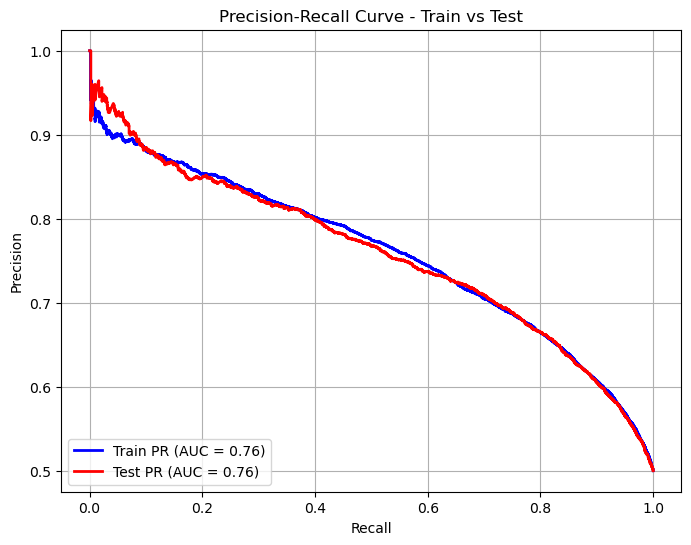

In [48]:
# Prédire les probabilités pour la classe positive
y_scores_train = best_model.predict_proba(X_train)[:, 1]
y_scores_test = best_model.predict_proba(X_test)[:, 1]

# Calcul des courbes PR
precision_train, recall_train, _ = precision_recall_curve(y_train, y_scores_train)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_scores_test)

# Calcul des AUC PR
auc_pr_train = auc(recall_train, precision_train)
auc_pr_test = auc(recall_test, precision_test)

# Tracer les courbes Precision-Recall
plt.figure(figsize=(8, 6))
plt.plot(recall_train, precision_train, color='blue', lw=2, label=f'Train PR (AUC = {auc_pr_train:.2f})')
plt.plot(recall_test, precision_test, color='red', lw=2, label=f'Test PR (AUC = {auc_pr_test:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Train vs Test")
plt.legend(loc="lower left")
plt.grid()

**Regardons la stabilité de l'AUC du meilleur modèle sur chaque fold du meilleur modèle**

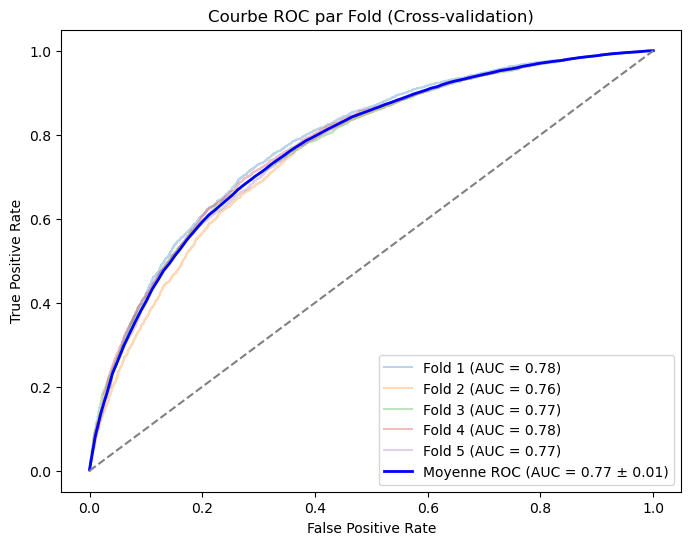

In [50]:
# Utilisation avec un GridSearchCV entraîné
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds stratifiés
plot_roc_folds(grid_search, X_train, y_train, cv)

**Affichons la matrice de confusion avec le seuil optimal**

Sur le fichier d'entraînement :

Seuil optimal train :  0.0444977026396394


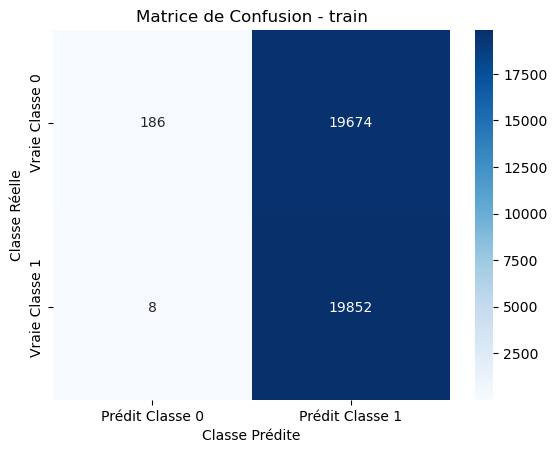

In [52]:
print("Seuil optimal train : ", optimal_threshold_train)

# Appliquer le Seuil Optimal
y_pred = (y_proba_train >= optimal_threshold_train).astype(int)

# Calcul de la matrice de confusion
cm = confusion_matrix(y_train, y_pred)

# Transformation en DataFrame avec des labels
df_cm = pd.DataFrame(cm, index=["Vraie Classe 0", "Vraie Classe 1"], 
                         columns=["Prédit Classe 0", "Prédit Classe 1"])

sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel("Classe Réelle")
plt.xlabel("Classe Prédite")
plt.title("Matrice de Confusion - train")
plt.show()

Sur le fichier de test:

Seuil optimal test :  0.04158866266805545


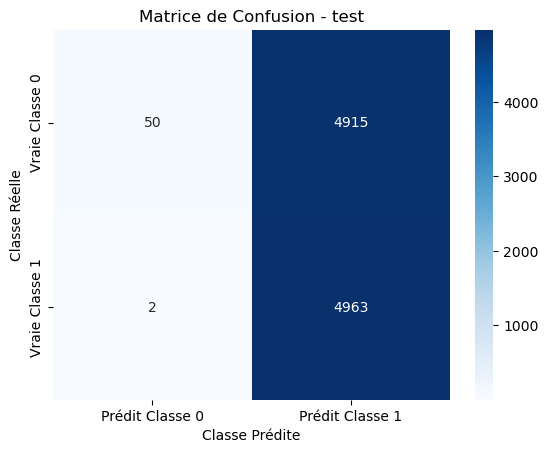

In [54]:
print("Seuil optimal test : ", optimal_threshold_test)

# Appliquer le Seuil Optimal
y_pred = (y_proba_test >= optimal_threshold_test).astype(int)

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Transformation en DataFrame avec des labels
df_cm = pd.DataFrame(cm, index=["Vraie Classe 0", "Vraie Classe 1"], 
                         columns=["Prédit Classe 0", "Prédit Classe 1"])

sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel("Classe Réelle")
plt.xlabel("Classe Prédite")
plt.title("Matrice de Confusion - test")
plt.show()

### 3.4 - Simuler avec DecisionTree

2 hyperparamètres :

- max_depth (Profondeur maximale de l'arbre)
    - Description : Détermine la profondeur maximale de l'arbre de décision. Si ce paramètre est défini sur None, l'arbre continuera à se diviser jusqu'à ce qu'il atteigne les feuilles parfaites (c'est-à-dire qu'il n'y ait plus d'amélioration possible dans les divisions).
    - Impact :
          - Profondeur trop petite : L'arbre peut être sous-ajusté (underfitting) et ne pourra pas capturer toute la complexité des données.
          - Profondeur trop grande : L'arbre peut être sur-ajusté (overfitting) et s'adapter trop bien aux bruits ou aux détails spécifiques des données d'entraînement.
    - Utilité : C'est un hyperparamètre essentiel, car il contrôle directement la complexité du modèle et la capacité de l'arbre à généraliser.
  
- min_samples_split (Nombre minimum d'échantillons requis pour diviser un noeud)
    - Description : Ce paramètre définit le nombre minimum d'échantillons nécessaires pour effectuer une division dans un noeud. Si un noeud contient moins de ce nombre d'échantillons, il ne sera pas divisé, et il deviendra une feuille.
    - Impact :
        - Valeur élevée : Cela empêche la division de noeuds lorsque les sous-groupes sont trop petits, ce qui peut limiter la capacité de l'arbre à s'adapter aux petites variations des données. Cela peut être utile pour réduire le surajustement.
        - Valeur faible : Si ce paramètre est trop petit, l'arbre peut devenir trop spécifique aux données d'entraînement, ce qui entraîne un surajustement.
    - Utilité : Ce paramètre aide à contrôler la taille de l'arbre et à éviter des divisions inutiles ou trop petites.


In [56]:
print("📂 Lancement du traitement DecisionTreeClassifier...")
start_time = timeit.default_timer()

# Initialisation du modèle
base_model = DecisionTreeClassifier(random_state=42)  # Utilisation d'un solver adapté

# Paramètres à tester dans GridSearchCV
param_grid = {
    'max_depth': [3, 5, 10, None],  # Profondeur maximale de l'arbre
    'min_samples_split': [2, 5, 10]  # Nombre minimum d'échantillons pour diviser un noeud
}

grid_search = GridSearchCV(
    base_model,
    param_grid=param_grid,
    scoring=metrics,
    refit="business_score",
    cv=5,
    n_jobs=-1,
    return_train_score=True
)
grid_search.fit(X_train, y_train)

# Sélectionner le meilleur modèle de GridSearchCV
best_model = grid_search.best_estimator_

# Tracer la courbe ROC Curve
plt = print_ROC_curve_cv(best_model, X_train, y_train, X_test, y_test, cv=5)

# Sauvegarder le graphique dans un fichier
roc_curve_path = "roc_curve.png"
plt.savefig(roc_curve_path)
plt.close()

# Tracer la courbe PR Curve
plt = print_PR_curve(best_model, X_train, y_train, X_test, y_test)

# Sauvegarder le graphique dans un fichier
pr_curve_path = "pr_curve.png"
plt.savefig(pr_curve_path)
plt.close()

# Faire des prédictions de probabilité sur l'ensemble de test
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positive

# Faire des prédictions de probabilité sur l'ensemble de train
y_pred_proba_train = best_model.predict_proba(X_train)[:, 1]  # Probabilités pour la classe positive

# Calculer l'AUC
auc_score_test = roc_auc_score(y_test, y_pred_proba_test)

# Calculer le seuil optimal test et train
optimal_threshold_train, min_business_score_train = find_optimal_threshold_business(y_train, y_pred_proba_train, calculate_errors_cost)
print("📂", f"Seuil optimal train: {optimal_threshold_train:.4f}, Business Score minimal : {min_business_score_train:.4f}")

optimal_threshold_test, min_business_score_test = find_optimal_threshold_business(y_test, y_pred_proba_test, calculate_errors_cost)
print("📂", f"Seuil optimal test: {optimal_threshold_test:.4f}, Business Score minimal : {min_business_score_test:.4f}")

save_model_mlflow(grid_search, "DecisionTreeClassifier_gridSearchCV", metrics, roc_curve_path, pr_curve_path, auc_score_test, optimal_threshold_test, min_business_score_test,
                 optimal_threshold_train, min_business_score_train)

# Supprimer le fichier temporaire
os.remove(roc_curve_path)
os.remove(pr_curve_path)

📂 Lancement du traitement DecisionTreeClassifier...
📂 Seuil optimal train: 0.1667, Business Score minimal : 19860.0000
📂 Seuil optimal test: 0.1667, Business Score minimal : 4965.0000
📂 Durée depuis le début :  117.783  - Fin entraînement DecisionTreeClassifier_gridSearchCV ...
📂 Durée depuis le début :  117.783  - Début tracking MLFlow DecisionTreeClassifier_gridSearchCV ...


Registered model 'DecisionTreeClassifier_gridSearchCV' already exists. Creating a new version of this model...
2025/02/23 17:31:39 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DecisionTreeClassifier_gridSearchCV, version 3


best_business_score : -14848.2
mean_fit_time : 7.008
mean_business_score : -14848.2
mean_accuracy : 0.6512839879154079
mean_AUC : 0.7033163666308672
mean_f1_macro : 0.6506288971281606
mean_precision : 0.6524553732709388
mean_recall : 0.6512839879154078
🏃 View run luminous-mole-890 at: http://127.0.0.1:5000/#/experiments/17/runs/32cdb72bfbb847a99b88857a895db1ec
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/17
Modèle enregistré en version 2.20.1
📂 Durée depuis le début :  123.805  - Fin tracking MLFlow DecisionTreeClassifier_gridSearchCV ...
✅ Fin traitement DecisionTreeClassifier_gridSearchCV


Created version '3' of model 'DecisionTreeClassifier_gridSearchCV'.


In [57]:
print_result_CV_as_dataframe(grid_search, metrics) 

Résultats de la validation croisée :


,params_,mean_score_AUC,mean_score_accuracy,mean_score_business_score,mean_score_f1_macro,mean_score_precision,mean_score_recall
0,"{'max_depth': 5, 'min_samples_split': 10}",0.703316,0.651284,-14848.2,0.650629,0.652455,0.651284
1,"{'max_depth': 5, 'min_samples_split': 2}",0.703316,0.651284,-14848.2,0.650629,0.652455,0.651284
2,"{'max_depth': 5, 'min_samples_split': 5}",0.703316,0.651284,-14848.2,0.650629,0.652455,0.651284
3,"{'max_depth': 10, 'min_samples_split': 2}",0.669336,0.638142,-15235.2,0.637781,0.638687,0.638142
4,"{'max_depth': 10, 'min_samples_split': 10}",0.671319,0.637739,-15236.6,0.637396,0.638259,0.637739
5,"{'max_depth': 10, 'min_samples_split': 5}",0.669811,0.638167,-15262.0,0.637820,0.638695,0.638167
6,"{'max_depth': 3, 'min_samples_split': 10}",0.683224,0.647080,-17761.6,0.645497,0.649745,0.647080
7,"{'max_depth': 3, 'min_samples_split': 2}",0.683224,0.647080,-17761.6,0.645497,0.649745,0.647080
8,"{'max_depth': 3, 'min_samples_split': 5}",0.683224,0.647080,-17761.6,0.645497,0.649745,0.647080
9,"{'max_depth': None, 'min_samples_split': 2}",0.588369,0.588369,-17979.6,0.588352,0.588383,0.588369


**Traçons les histogrammes des probabilités de prédiction**

Sur le ficher train :

<Axes: ylabel='Count'>

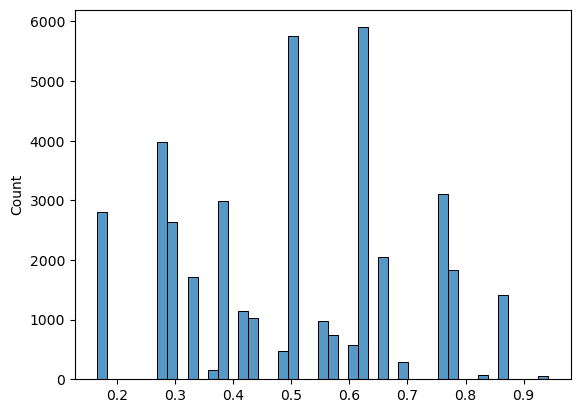

In [59]:
# Récupérer les probabilités prédites sur un jeu d'entraînement
y_proba_train = best_model.predict_proba(X_train)[:,1]

# Afficher l'histogramme
sns.histplot(y_proba_train)

Sur le fichier test :

<Axes: ylabel='Count'>

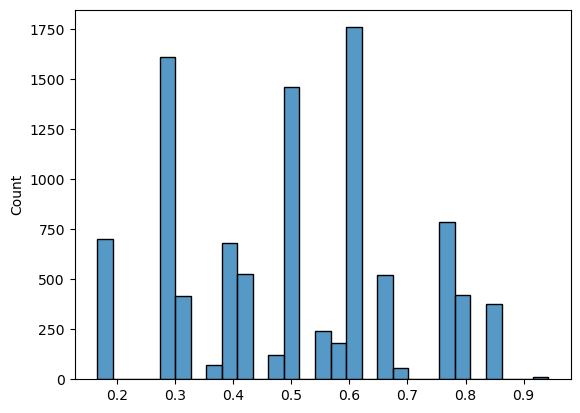

In [61]:
# Récupérer les probabilités prédites sur un jeu d'entraînement
y_proba_test = best_model.predict_proba(X_test)[:,1]

# Afficher l'histogramme
sns.histplot(y_proba_test)

**Analyse du seuil optimal par rapport au score métier**

Classe 0 : négatif / Classe 1 : positif

- Un seuil bas → Plus de refus (prêts non accordés) → Réduit FN (mauvais client à qui on accorde un prêt) mais augmente FP (bon client considéré comme mauvais).
- Un seuil haut → Plus de prêts accordés → Réduit FP mais augmente FN.
- Le seuil optimal est celui qui minimise ton score métier  : 10 × FN + FP.

**Affichons la matrice de confusion avec le seuil optimal**

Sur le fichier d'entraînement :

Seuil optimal train :  0.16666666666666666


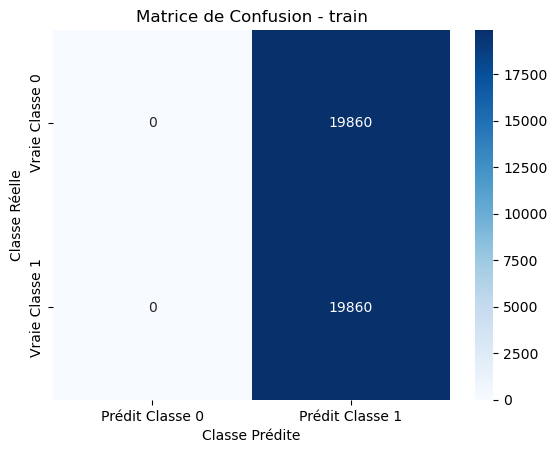

In [64]:
print("Seuil optimal train : ", optimal_threshold_train)

# Appliquer le Seuil Optimal
y_pred = (y_proba_train >= optimal_threshold_train).astype(int)

# Calcul de la matrice de confusion
cm = confusion_matrix(y_train, y_pred)

# Transformation en DataFrame avec des labels
df_cm = pd.DataFrame(cm, index=["Vraie Classe 0", "Vraie Classe 1"], 
                         columns=["Prédit Classe 0", "Prédit Classe 1"])

sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel("Classe Réelle")
plt.xlabel("Classe Prédite")
plt.title("Matrice de Confusion - train")
plt.show()

Sur le fichier de test:

Seuil optimal test :  0.16666666666666666


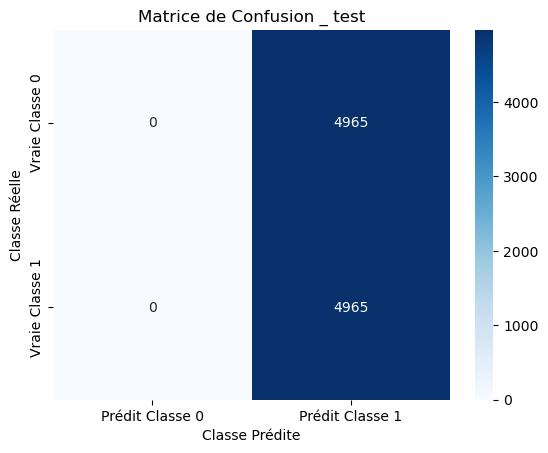

In [66]:
print("Seuil optimal test : ", optimal_threshold_test)

# Appliquer le Seuil Optimal
y_pred = (y_proba_test >= optimal_threshold_test).astype(int)

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Transformation en DataFrame avec des labels
df_cm = pd.DataFrame(cm, index=["Vraie Classe 0", "Vraie Classe 1"], 
                         columns=["Prédit Classe 0", "Prédit Classe 1"])

sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel("Classe Réelle")
plt.xlabel("Classe Prédite")
plt.title("Matrice de Confusion _ test")
plt.show()

**Affichons la courbe ROC**

<module 'matplotlib.pyplot' from 'C:\\Users\\admin\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

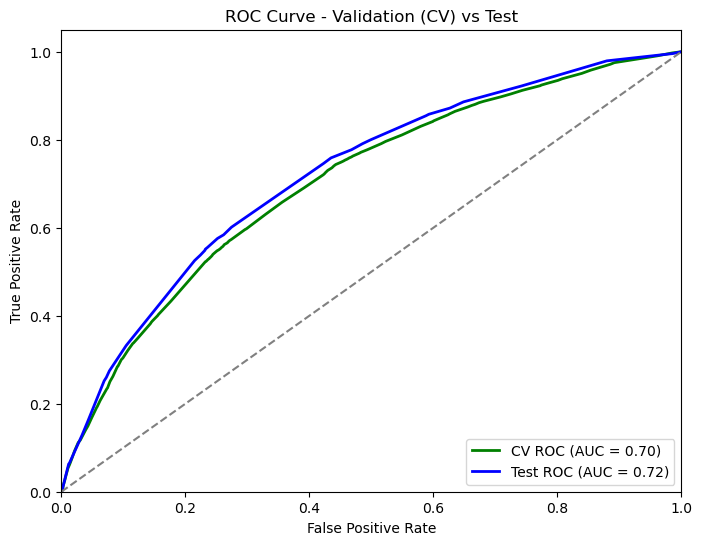

In [68]:
print_ROC_curve_cv(best_model, X_train, y_train, X_test, y_test, cv=5)

**Regardons la stabilité de l'AUC du meilleur modèle sur chaque fold**

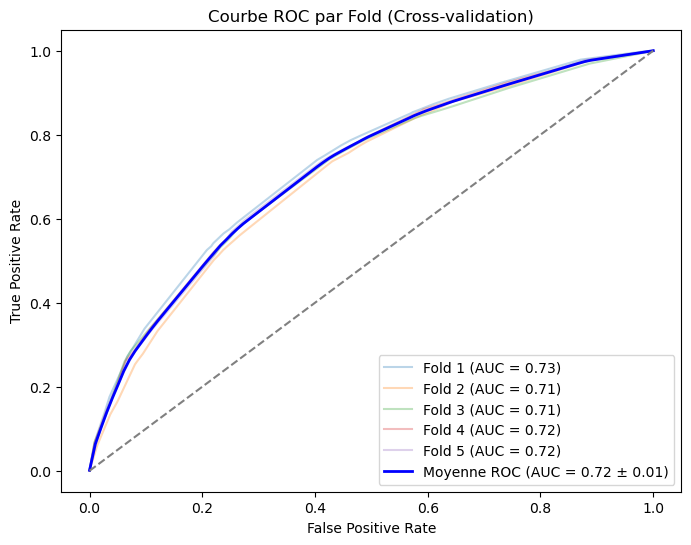

In [70]:
# Utilisation avec un GridSearchCV entraîné
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds stratifiés
plot_roc_folds(grid_search, X_train, y_train, cv)

### 3.5 - Simuler avec LightGBM

Les 3 hyperparamètres utilisés sont :
- n_estimators: Nombre d'arbres (plus il y en a, plus c'est précis mais long).
- learning_rate: Plus c'est bas, plus le modèle apprend lentement mais mieux.
- num_leaves: Nombre de feuilles par arbre (plus il y en a, plus le modèle est expressif).

In [92]:
print("📂 Lancement du traitement LightGBM...")
start_time = timeit.default_timer()

# Initialisation du modèle
base_model = LGBMClassifier(random_state=42)  # Utilisation d'un solver adapté

# Paramètres à tester dans GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 500],  # Nombre d'arbres
    'learning_rate': [0.01, 0.1, 0.2],  # Taux d'apprentissage
    'num_leaves': [7, 15, 31],  # Nombre de feuilles dans chaque arbre
}

grid_search = GridSearchCV(
    base_model,
    param_grid=param_grid,
    scoring=metrics,
    refit="business_score",
    cv=5,
    n_jobs=-1,
    return_train_score=True
)
grid_search.fit(X_train, y_train)

# Sélectionner le meilleur modèle de GridSearchCV
best_model = grid_search.best_estimator_

# Tracer la courbe ROC Curve
plt = print_ROC_curve_cv(best_model, X_train, y_train, X_test, y_test, cv=5)

# Sauvegarder le graphique dans un fichier
roc_curve_path = "roc_curve.png"
plt.savefig(roc_curve_path)
plt.close()

# Tracer la courbe PR Curve
plt = print_PR_curve(best_model, X_train, y_train, X_test, y_test)

# Sauvegarder le graphique dans un fichier
pr_curve_path = "pr_curve.png"
plt.savefig(pr_curve_path)
plt.close()

# Faire des prédictions de probabilité sur l'ensemble de test
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positive

# Faire des prédictions de probabilité sur l'ensemble de train
y_pred_proba_train = best_model.predict_proba(X_train)[:, 1]  # Probabilités pour la classe positive

# Calculer l'AUC
auc_score_test = roc_auc_score(y_test, y_pred_proba_test)

# Calculer le seuil optimal test et train
optimal_threshold_train, min_business_score_train = find_optimal_threshold_business(y_train, y_pred_proba_train, calculate_errors_cost)
print("📂", f"Seuil optimal train: {optimal_threshold_train:.4f}, Business Score minimal : {min_business_score_train:.4f}")

optimal_threshold_test, min_business_score_test = find_optimal_threshold_business(y_test, y_pred_proba_test, calculate_errors_cost)
print("📂", f"Seuil optimal test: {optimal_threshold_test:.4f}, Business Score minimal : {min_business_score_test:.4f}")

save_model_mlflow(grid_search, "LightGBM_gridSearchCV", metrics, roc_curve_path, pr_curve_path, auc_score_test, optimal_threshold_test, min_business_score_test,
                 optimal_threshold_train, min_business_score_train)

# Supprimer le fichier temporaire
os.remove(roc_curve_path)
os.remove(pr_curve_path)

📂 Lancement du traitement LightGBM...
[LightGBM] [Info] Number of positive: 19860, number of negative: 19860
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45810
[LightGBM] [Info] Number of data points in the train set: 39720, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 15888, number of negative: 15888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45355
[LightGBM] [Info] Number of data points in the train set: 31776, number of used features: 357
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 15888, number of negative: 15888
[LightGBM

Registered model 'LightGBM_gridSearchCV' already exists. Creating a new version of this model...
2025/02/23 19:08:18 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LightGBM_gridSearchCV, version 3


best_business_score : -12963.6
mean_fit_time : 29.905
mean_business_score : -12963.6
mean_accuracy : 0.7038519637462236
mean_AUC : 0.7716133528861142
mean_f1_macro : 0.7038415614490351
mean_precision : 0.7038813275725005
mean_recall : 0.7038519637462235
🏃 View run useful-hog-631 at: http://127.0.0.1:5000/#/experiments/17/runs/56e2001e2ec645ecbe465639ae5c0775
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/17
Modèle enregistré en version 2.20.1
📂 Durée depuis le début :  1738.04  - Fin tracking MLFlow LightGBM_gridSearchCV ...
✅ Fin traitement LightGBM_gridSearchCV


Created version '3' of model 'LightGBM_gridSearchCV'.


In [93]:
print_result_CV_as_dataframe(grid_search, metrics)

Résultats de la validation croisée :


,params_,mean_score_AUC,mean_score_accuracy,mean_score_business_score,mean_score_f1_macro,mean_score_precision,mean_score_recall
0,"{'learning_rate': 0.1, 'n_estimators': 100, 'n...",0.771613,0.703852,-12963.6,0.703842,0.703881,0.703852
1,"{'learning_rate': 0.1, 'n_estimators': 500, 'n...",0.771906,0.702996,-12983.0,0.702993,0.703004,0.702996
2,"{'learning_rate': 0.1, 'n_estimators': 500, 'n...",0.774079,0.705463,-12992.2,0.705456,0.705483,0.705463
3,"{'learning_rate': 0.1, 'n_estimators': 500, 'n...",0.768841,0.703348,-12998.2,0.703345,0.703359,0.703348
4,"{'learning_rate': 0.1, 'n_estimators': 200, 'n...",0.771350,0.704003,-13005.6,0.703996,0.704023,0.704003
5,"{'learning_rate': 0.1, 'n_estimators': 200, 'n...",0.773161,0.703625,-13012.2,0.703617,0.703649,0.703625
6,"{'learning_rate': 0.1, 'n_estimators': 100, 'n...",0.771956,0.702115,-13033.2,0.702111,0.702125,0.702115
7,"{'learning_rate': 0.2, 'n_estimators': 100, 'n...",0.770421,0.702669,-13075.6,0.702664,0.702681,0.702669
8,"{'learning_rate': 0.01, 'n_estimators': 500, '...",0.769276,0.700881,-13104.2,0.700878,0.700891,0.700881
9,"{'learning_rate': 0.2, 'n_estimators': 200, 'n...",0.766066,0.698212,-13120.0,0.698209,0.698221,0.698212


**Traçons les histogrammes des probabilités de prédiction**

Sur le ficher train :

<Axes: ylabel='Count'>

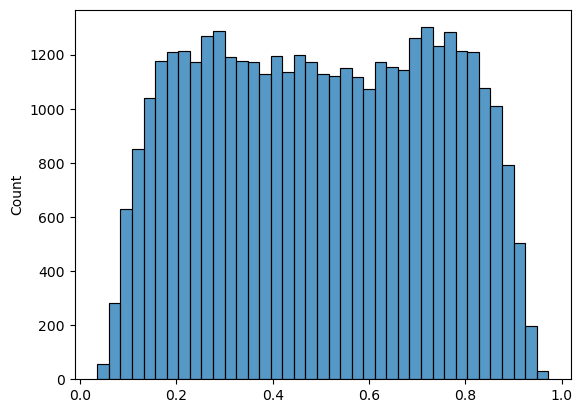

In [94]:
# Récupérer les probabilités prédites sur un jeu d'entraînement
y_proba_train = best_model.predict_proba(X_train)[:,1]

# Afficher l'histogramme
sns.histplot(y_proba_train)

Sur le ficher test :

<Axes: ylabel='Count'>

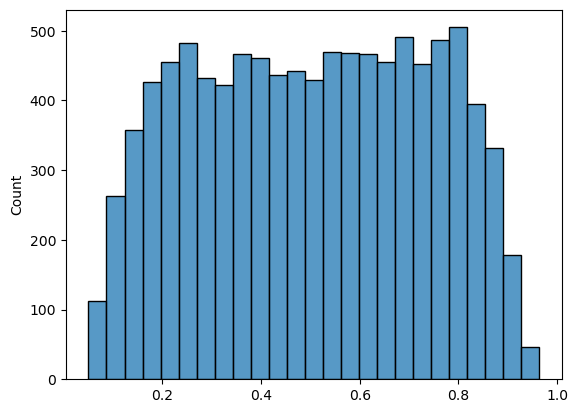

In [95]:
# Récupérer les probabilités prédites sur un jeu d'entraînement
y_proba_test = best_model.predict_proba(X_test)[:,1]

# Afficher l'histogramme
sns.histplot(y_proba_test)

**Affichons la matrice de confusion avec le seuil optimal**

Sur le fichier d'entraînement :

Seuil optimal train :  0.18144287319250132


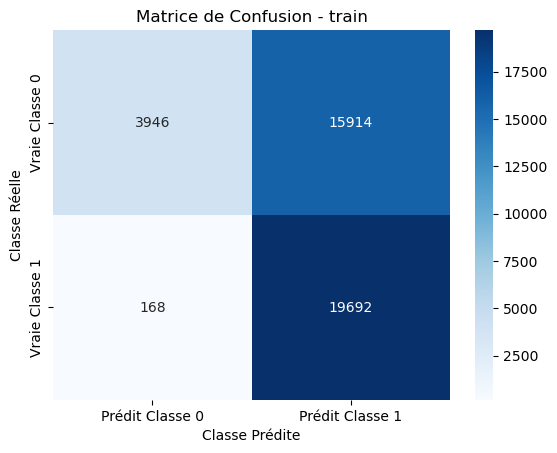

In [96]:
print("Seuil optimal train : ", optimal_threshold_train)

# Appliquer le Seuil Optimal
y_pred = (y_proba_train >= optimal_threshold_train).astype(int)

# Calcul de la matrice de confusion
cm = confusion_matrix(y_train, y_pred)

# Transformation en DataFrame avec des labels
df_cm = pd.DataFrame(cm, index=["Vraie Classe 0", "Vraie Classe 1"], 
                         columns=["Prédit Classe 0", "Prédit Classe 1"])

sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel("Classe Réelle")
plt.xlabel("Classe Prédite")
plt.title("Matrice de Confusion - train")
plt.show()

Sur le fichier de test :

Seuil optimal test :  0.12950446505820803


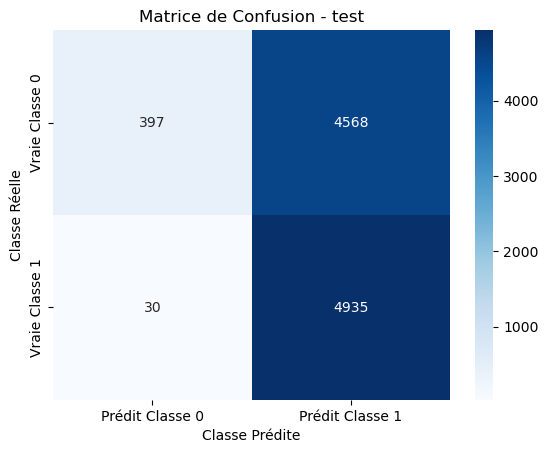

In [97]:
print("Seuil optimal test : ", optimal_threshold_test)

# Appliquer le Seuil Optimal
y_pred = (y_proba_test >= optimal_threshold_test).astype(int)

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Transformation en DataFrame avec des labels
df_cm = pd.DataFrame(cm, index=["Vraie Classe 0", "Vraie Classe 1"], 
                         columns=["Prédit Classe 0", "Prédit Classe 1"])

sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel("Classe Réelle")
plt.xlabel("Classe Prédite")
plt.title("Matrice de Confusion - test")
plt.show()

**Affichons la courbe ROC**

[LightGBM] [Info] Number of positive: 15888, number of negative: 15888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45355
[LightGBM] [Info] Number of data points in the train set: 31776, number of used features: 357
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 15888, number of negative: 15888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45380
[LightGBM] [Info] Number of data points in the train set: 31776, number of used features: 357
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 15888, number of negative: 15888
[LightGBM] [Info] Auto-choosing col-wise multi-

<module 'matplotlib.pyplot' from 'C:\\Users\\admin\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

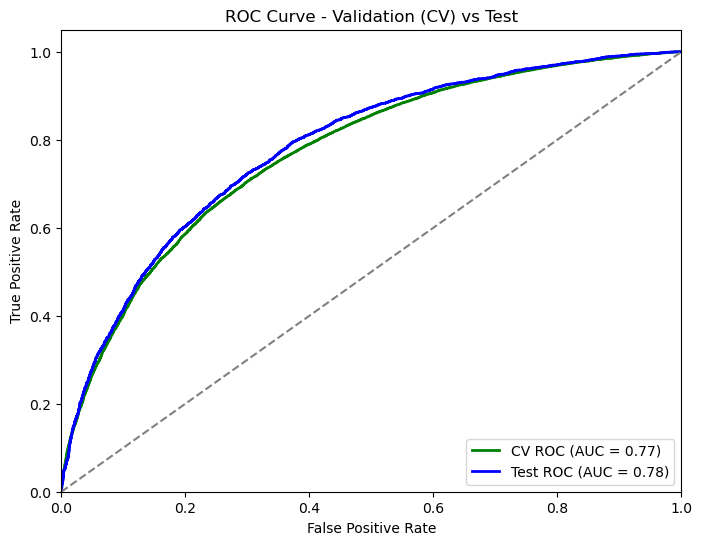

In [98]:
print_ROC_curve_cv(best_model, X_train, y_train, X_test, y_test, cv=5)

**Regardons la stabilité de l'AUC du meilleur modèle sur chaque fold**

[LightGBM] [Info] Number of positive: 15888, number of negative: 180916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.329047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46913
[LightGBM] [Info] Number of data points in the train set: 196804, number of used features: 371
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432469
[LightGBM] [Info] Start training from score -2.432469
[LightGBM] [Info] Number of positive: 15888, number of negative: 180916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.469899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47008
[LightGBM] [Info] Number of data points in the train set: 196804, number of used features: 371
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432469
[LightGBM] [Info] Start training from score -2.432469
[Lig

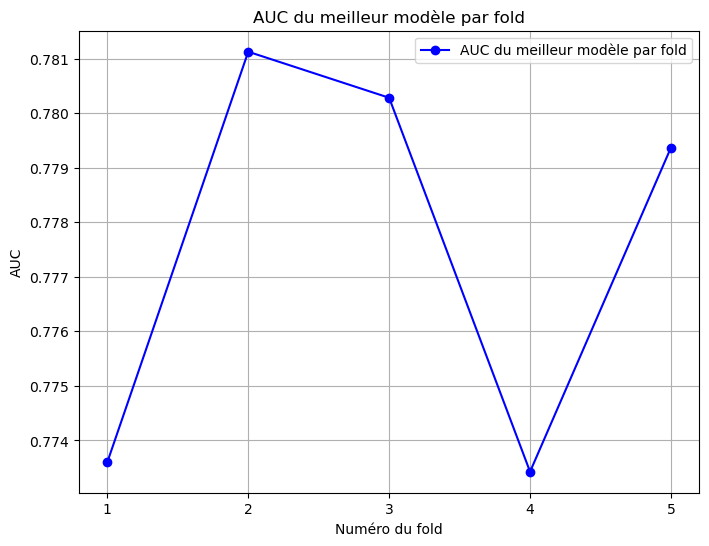

In [132]:
# Renommer les colonnes pour éliminer les caractères spéciaux
X_train.columns = X_train.columns.str.replace('[^A-Za-z0-9_]', '_', regex=True)
X_test.columns = X_test.columns.str.replace('[^A-Za-z0-9_]', '_', regex=True)

# Validation croisée manuelle pour récupérer l'AUC de chaque fold avec le meilleur modèle
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_per_fold = []

for train_idx, test_idx in kf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]

    # Entraîner le modèle sur chaque fold avec les meilleurs paramètres
    best_model.fit(X_train_fold, y_train_fold)
    
    # Prédictions sur le fold de test
    y_probs = best_model.predict_proba(X_test_fold)[:, 1]  # Probabilité pour la classe positive
    
    # Calculer l'AUC pour ce fold
    auc = roc_auc_score(y_test_fold, y_probs)
    auc_per_fold.append(auc)

# Tracer l'AUC pour chaque fold
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(auc_per_fold) + 1), auc_per_fold, marker='o', linestyle='-', color='b', label='AUC du meilleur modèle par fold')
plt.title('AUC du meilleur modèle par fold')
plt.xlabel('Numéro du fold')
plt.ylabel('AUC')
plt.xticks(np.arange(1, len(auc_per_fold) + 1))
plt.grid(True)
plt.legend()
plt.show()

### 3.6 - Conclusions

Le meilleur score métier a été obtenu avec LightGBM (- 12 963), avec les hyperparamètres :
- learning_rate = 0.1
- n_estimators = 100
- num_leaves = 31

Il s'agit du score le plus proche de 0, donc le plus performant pour minimiser la fonction de coût 10*FN + FP.
Son temps de traitement est beaucoup plus rapide que le LogisticRegression. Le plus rapide est DecisionTreeClassifier, mais le score métier était moins bon.

L'AUC moyen obtenu avec LightGBM lors de la validation croisée est 0.77. L'AUC est de 0.78 sur le fichier de test. Présence d'un très léger surapprentissage.

**L'algorithme choisi est LightGBM avec les paramètres suivants.**

Dans la suite nous affinerons les hyperparamètres pour optimiser le modèle.

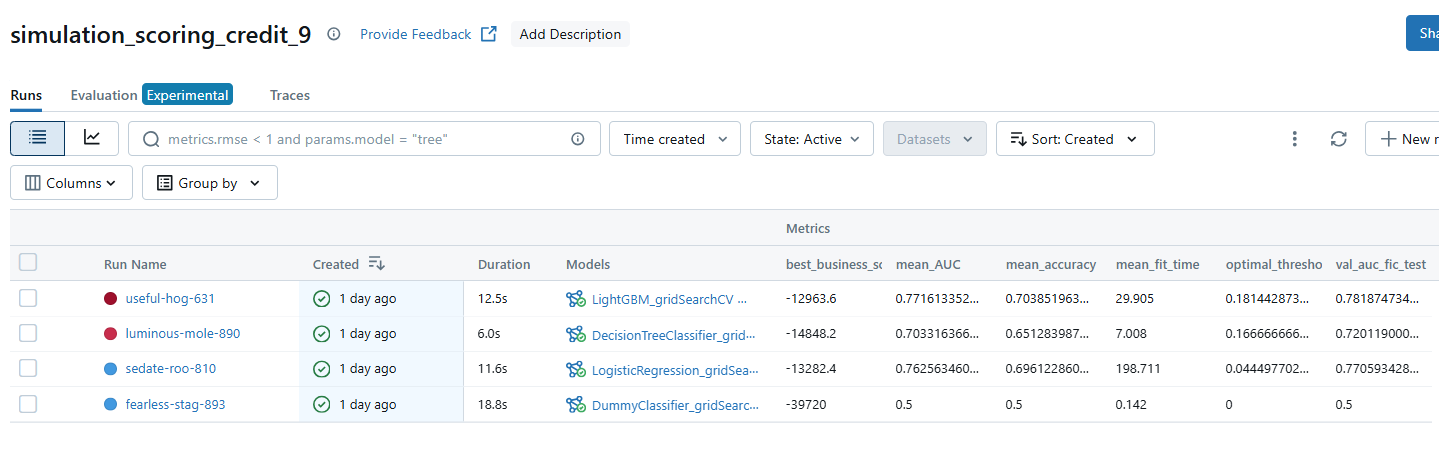

## 4 - Optimisation du modèle LightGBM

Le meilleur score métier a été obtenu avec LightGBM (- 12 963), avec les hyperparamètres :

- learning_rate = 0.1
- n_estimators = 100
- num_leaves = 31

Les hyperparamètres en entrée du GridSearch était :
- n_estimators: [100, 200, 500]
- learning_rate: [0.01, 0.1, 0.2]
- num_leaves: [7, 15, 31]

En 7ème position, on trouvait un cas avec learning_rate = 0.2. Donc le meilleur learning_rate est peut-être entre 0.05 et 0.15.
On peut également essayer des valeurs de num_leaves entre 20 et 40.

In [26]:
print("📂 Lancement du traitement optimisation LightGBM...")
start_time = timeit.default_timer()

# Initialisation du modèle
base_model = LGBMClassifier(random_state=42)  # Utilisation d'un solver adapté

# Paramètres à tester dans GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 500],  # Nombre d'arbres
    'learning_rate': [0.05, 0.1, 0.15],  # Taux d'apprentissage
    'num_leaves': [20, 31, 40],  # Nombre de feuilles dans chaque arbre
}

grid_search = GridSearchCV(
    base_model,
    param_grid=param_grid,
    scoring=metrics,
    refit="business_score",
    cv=5,
    n_jobs=-1,
    return_train_score=True
)
grid_search.fit(X_train, y_train)

# Sélectionner le meilleur modèle de GridSearchCV
best_model = grid_search.best_estimator_

# Tracer la courbe ROC Curve
plt = print_ROC_curve_cv(best_model, X_train, y_train, X_test, y_test, cv=5)

# Sauvegarder le graphique dans un fichier
roc_curve_path = "roc_curve.png"
plt.savefig(roc_curve_path)
plt.close()

# Tracer la courbe PR Curve
plt = print_PR_curve(best_model, X_train, y_train, X_test, y_test)

# Sauvegarder le graphique dans un fichier
pr_curve_path = "pr_curve.png"
plt.savefig(pr_curve_path)
plt.close()

# Faire des prédictions de probabilité sur l'ensemble de test
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positive

# Faire des prédictions de probabilité sur l'ensemble de train
y_pred_proba_train = best_model.predict_proba(X_train)[:, 1]  # Probabilités pour la classe positive

# Calculer l'AUC
auc_score_test = roc_auc_score(y_test, y_pred_proba_test)

# Calculer le seuil optimal test et train
optimal_threshold_train, min_business_score_train = find_optimal_threshold_business(y_train, y_pred_proba_train, calculate_errors_cost)
print("📂", f"Seuil optimal train: {optimal_threshold_train:.4f}, Business Score minimal : {min_business_score_train:.4f}")

optimal_threshold_test, min_business_score_test = find_optimal_threshold_business(y_test, y_pred_proba_test, calculate_errors_cost)
print("📂", f"Seuil optimal test: {optimal_threshold_test:.4f}, Business Score minimal : {min_business_score_test:.4f}")

save_model_mlflow(grid_search, "Optimisation_LightGBM_gridSearchCV", metrics, roc_curve_path, pr_curve_path, auc_score_test, optimal_threshold_test, min_business_score_test,
                 optimal_threshold_train, min_business_score_train)

# Supprimer le fichier temporaire
os.remove(roc_curve_path)
os.remove(pr_curve_path)

📂 Lancement du traitement optimisation LightGBM...
[LightGBM] [Info] Number of positive: 19860, number of negative: 19860
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45871
[LightGBM] [Info] Number of data points in the train set: 39720, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 15888, number of negative: 15888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45398
[LightGBM] [Info] Number of data points in the train set: 31776, number of used features: 355
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 15888, number of negative: 15

Successfully registered model 'Optimisation_LightGBM_gridSearchCV'.
2025/02/25 09:29:13 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Optimisation_LightGBM_gridSearchCV, version 1


best_business_score : -13063.4
mean_fit_time : 71.873
mean_business_score : -13063.4
mean_accuracy : 0.7046576032225579
mean_AUC : 0.7746752950411187
mean_f1_macro : 0.7046473401309437
mean_precision : 0.7046857961086815
mean_recall : 0.7046576032225579
🏃 View run suave-bee-811 at: http://127.0.0.1:5000/#/experiments/17/runs/9facdd4e621b4c06b7959308fcb533fa
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/17
Modèle enregistré en version 2.20.1
📂 Durée depuis le début :  2001.859  - Fin tracking MLFlow Optimisation_LightGBM_gridSearchCV ...
✅ Fin traitement Optimisation_LightGBM_gridSearchCV


Created version '1' of model 'Optimisation_LightGBM_gridSearchCV'.


In [41]:
print_result_CV_as_dataframe(grid_search, metrics)

Résultats de la validation croisée :


,params_,mean_score_AUC,mean_score_accuracy,mean_score_business_score,mean_score_f1_macro,mean_score_precision,mean_score_recall
0,"{'learning_rate': 0.05, 'n_estimators': 500, '...",0.774675,0.704658,-13063.4,0.704647,0.704686,0.704658
1,"{'learning_rate': 0.1, 'n_estimators': 100, 'n...",0.772463,0.702845,-13092.2,0.702839,0.702860,0.702845
2,"{'learning_rate': 0.1, 'n_estimators': 200, 'n...",0.771632,0.702895,-13095.4,0.702887,0.702918,0.702895
3,"{'learning_rate': 0.05, 'n_estimators': 200, '...",0.773600,0.703474,-13098.0,0.703466,0.703496,0.703474
4,"{'learning_rate': 0.05, 'n_estimators': 200, '...",0.773935,0.703701,-13103.4,0.703691,0.703728,0.703701
5,"{'learning_rate': 0.1, 'n_estimators': 200, 'n...",0.771045,0.701737,-13106.4,0.701730,0.701757,0.701737
6,"{'learning_rate': 0.05, 'n_estimators': 200, '...",0.774035,0.703751,-13106.6,0.703740,0.703783,0.703751
7,"{'learning_rate': 0.1, 'n_estimators': 100, 'n...",0.772251,0.701687,-13112.2,0.701677,0.701712,0.701687
8,"{'learning_rate': 0.1, 'n_estimators': 200, 'n...",0.773000,0.703399,-13147.2,0.703385,0.703437,0.703399
9,"{'learning_rate': 0.15, 'n_estimators': 100, '...",0.771094,0.701334,-13154.6,0.701327,0.701353,0.701334


On constate que le temps moyen de traitement est plus long avec learning_rate de 0.05 pour un score métier mmoyen bon au final. Je reviens à une valeur de 0.1.

In [44]:
print("📂 Lancement du traitement optimisation LightGBM...")
start_time = timeit.default_timer()

# Initialisation du modèle
base_model = LGBMClassifier(random_state=42)  # Utilisation d'un solver adapté

# Paramètres à tester dans GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 500, 1000],  # Nombre d'arbres
    'learning_rate': [0.1],  # Taux d'apprentissage
    'num_leaves': [31, 64],  # Nombre de feuilles dans chaque arbre
}

grid_search = GridSearchCV(
    base_model,
    param_grid=param_grid,
    scoring=metrics,
    refit="business_score",
    cv=5,
    n_jobs=-1,
    return_train_score=True
)
grid_search.fit(X_train, y_train)

# Sélectionner le meilleur modèle de GridSearchCV
best_model = grid_search.best_estimator_

# Tracer la courbe ROC Curve
plt = print_ROC_curve_cv(best_model, X_train, y_train, X_test, y_test, cv=5)

# Sauvegarder le graphique dans un fichier
roc_curve_path = "roc_curve.png"
plt.savefig(roc_curve_path)
plt.close()

# Tracer la courbe PR Curve
plt = print_PR_curve(best_model, X_train, y_train, X_test, y_test)

# Sauvegarder le graphique dans un fichier
pr_curve_path = "pr_curve.png"
plt.savefig(pr_curve_path)
plt.close()

# Faire des prédictions de probabilité sur l'ensemble de test
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positive

# Faire des prédictions de probabilité sur l'ensemble de train
y_pred_proba_train = best_model.predict_proba(X_train)[:, 1]  # Probabilités pour la classe positive

# Calculer l'AUC
auc_score_test = roc_auc_score(y_test, y_pred_proba_test)

# Calculer le seuil optimal test et train
optimal_threshold_train, min_business_score_train = find_optimal_threshold_business(y_train, y_pred_proba_train, calculate_errors_cost)
print("📂", f"Seuil optimal train: {optimal_threshold_train:.4f}, Business Score minimal : {min_business_score_train:.4f}")

optimal_threshold_test, min_business_score_test = find_optimal_threshold_business(y_test, y_pred_proba_test, calculate_errors_cost)
print("📂", f"Seuil optimal test: {optimal_threshold_test:.4f}, Business Score minimal : {min_business_score_test:.4f}")

save_model_mlflow(grid_search, "Optimisation_LightGBM_gridSearchCV", metrics, roc_curve_path, pr_curve_path, auc_score_test, optimal_threshold_test, min_business_score_test,
                 optimal_threshold_train, min_business_score_train)

# Supprimer le fichier temporaire
os.remove(roc_curve_path)
os.remove(pr_curve_path)

📂 Lancement du traitement optimisation LightGBM...
[LightGBM] [Info] Number of positive: 19860, number of negative: 19860
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.167738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45871
[LightGBM] [Info] Number of data points in the train set: 39720, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 15888, number of negative: 15888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.171208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45398
[LightGBM] [Info] Number of data points in the train set: 31776, number of used features: 355
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 15888, number of negative: 15

Registered model 'Optimisation_LightGBM_gridSearchCV' already exists. Creating a new version of this model...
2025/02/25 10:32:39 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Optimisation_LightGBM_gridSearchCV, version 2


best_business_score : -13092.2
mean_fit_time : 38.834
mean_business_score : -13092.2
mean_accuracy : 0.7028449144008055
mean_AUC : 0.7724627401883678
mean_f1_macro : 0.7028393119172505
mean_precision : 0.7028597585315832
mean_recall : 0.7028449144008055
🏃 View run debonair-ox-392 at: http://127.0.0.1:5000/#/experiments/17/runs/6514d5bf72b74a73a28d72ff3206bc81
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/17
Modèle enregistré en version 2.20.1
📂 Durée depuis le début :  3020.653  - Fin tracking MLFlow Optimisation_LightGBM_gridSearchCV ...
✅ Fin traitement Optimisation_LightGBM_gridSearchCV


Created version '2' of model 'Optimisation_LightGBM_gridSearchCV'.


In [46]:
print_result_CV_as_dataframe(grid_search, metrics)

Résultats de la validation croisée :


,params_,mean_score_AUC,mean_score_accuracy,mean_score_business_score,mean_score_f1_macro,mean_score_precision,mean_score_recall
0,"{'learning_rate': 0.1, 'n_estimators': 100, 'n...",0.772463,0.702845,-13092.2,0.702839,0.702860,0.702845
1,"{'learning_rate': 0.1, 'n_estimators': 200, 'n...",0.771632,0.702895,-13095.4,0.702887,0.702918,0.702895
2,"{'learning_rate': 0.1, 'n_estimators': 100, 'n...",0.770312,0.700302,-13198.8,0.700297,0.700317,0.700302
3,"{'learning_rate': 0.1, 'n_estimators': 200, 'n...",0.769089,0.699824,-13236.8,0.699818,0.699839,0.699824
4,"{'learning_rate': 0.1, 'n_estimators': 500, 'n...",0.768792,0.699144,-13258.4,0.699132,0.699176,0.699144
5,"{'learning_rate': 0.1, 'n_estimators': 1000, '...",0.766563,0.696702,-13313.8,0.696699,0.696710,0.696702
6,"{'learning_rate': 0.1, 'n_estimators': 500, 'n...",0.767512,0.697029,-13359.8,0.697020,0.697052,0.697029
7,"{'learning_rate': 0.1, 'n_estimators': 1000, '...",0.767928,0.696652,-13469.0,0.696635,0.696693,0.696652


In [48]:
print("📂 Lancement du traitement optimisation LightGBM...")
start_time = timeit.default_timer()

# Initialisation du modèle
base_model = LGBMClassifier(random_state=42)  # Utilisation d'un solver adapté

# Paramètres à tester dans GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],  # Nombre d'arbres
    'learning_rate': [0.1],  # Taux d'apprentissage
    'num_leaves': [31],  # Nombre de feuilles dans chaque arbre
}

grid_search = GridSearchCV(
    base_model,
    param_grid=param_grid,
    scoring=metrics,
    refit="business_score",
    cv=5,
    n_jobs=-1,
    return_train_score=True
)
grid_search.fit(X_train, y_train)

# Sélectionner le meilleur modèle de GridSearchCV
best_model = grid_search.best_estimator_

# Tracer la courbe ROC Curve
plt = print_ROC_curve_cv(best_model, X_train, y_train, X_test, y_test, cv=5)

# Sauvegarder le graphique dans un fichier
roc_curve_path = "roc_curve.png"
plt.savefig(roc_curve_path)
plt.close()

# Tracer la courbe PR Curve
plt = print_PR_curve(best_model, X_train, y_train, X_test, y_test)

# Sauvegarder le graphique dans un fichier
pr_curve_path = "pr_curve.png"
plt.savefig(pr_curve_path)
plt.close()

# Faire des prédictions de probabilité sur l'ensemble de test
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positive

# Faire des prédictions de probabilité sur l'ensemble de train
y_pred_proba_train = best_model.predict_proba(X_train)[:, 1]  # Probabilités pour la classe positive

# Calculer l'AUC
auc_score_test = roc_auc_score(y_test, y_pred_proba_test)

# Calculer le seuil optimal test et train
optimal_threshold_train, min_business_score_train = find_optimal_threshold_business(y_train, y_pred_proba_train, calculate_errors_cost)
print("📂", f"Seuil optimal train: {optimal_threshold_train:.4f}, Business Score minimal : {min_business_score_train:.4f}")

optimal_threshold_test, min_business_score_test = find_optimal_threshold_business(y_test, y_pred_proba_test, calculate_errors_cost)
print("📂", f"Seuil optimal test: {optimal_threshold_test:.4f}, Business Score minimal : {min_business_score_test:.4f}")

save_model_mlflow(grid_search, "Optimisation_LightGBM_gridSearchCV", metrics, roc_curve_path, pr_curve_path, auc_score_test, optimal_threshold_test, min_business_score_test,
                 optimal_threshold_train, min_business_score_train)

# Supprimer le fichier temporaire
os.remove(roc_curve_path)
os.remove(pr_curve_path)

📂 Lancement du traitement optimisation LightGBM...
[LightGBM] [Info] Number of positive: 19860, number of negative: 19860
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.189911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45871
[LightGBM] [Info] Number of data points in the train set: 39720, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 15888, number of negative: 15888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.168606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45398
[LightGBM] [Info] Number of data points in the train set: 31776, number of used features: 355
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 15888, number of negative: 15

Registered model 'Optimisation_LightGBM_gridSearchCV' already exists. Creating a new version of this model...
2025/02/25 11:42:28 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Optimisation_LightGBM_gridSearchCV, version 3
Created version '3' of model 'Optimisation_LightGBM_gridSearchCV'.


best_business_score : -13092.2
mean_fit_time : 40.446
mean_business_score : -13092.2
mean_accuracy : 0.7028449144008055
mean_AUC : 0.7724627401883678
mean_f1_macro : 0.7028393119172505
mean_precision : 0.7028597585315832
mean_recall : 0.7028449144008055
🏃 View run mysterious-panda-892 at: http://127.0.0.1:5000/#/experiments/17/runs/9db5b467e7f6407a91d0861717457525
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/17
Modèle enregistré en version 2.20.1
📂 Durée depuis le début :  2336.485  - Fin tracking MLFlow Optimisation_LightGBM_gridSearchCV ...
✅ Fin traitement Optimisation_LightGBM_gridSearchCV


In [50]:
print_result_CV_as_dataframe(grid_search, metrics)

Résultats de la validation croisée :


,params_,mean_score_AUC,mean_score_accuracy,mean_score_business_score,mean_score_f1_macro,mean_score_precision,mean_score_recall
0,"{'learning_rate': 0.1, 'n_estimators': 100, 'n...",0.772463,0.702845,-13092.2,0.702839,0.702860,0.702845
1,"{'learning_rate': 0.1, 'n_estimators': 150, 'n...",0.772128,0.703600,-13106.0,0.703589,0.703630,0.703600
2,"{'learning_rate': 0.1, 'n_estimators': 50, 'nu...",0.768307,0.699522,-13278.8,0.699511,0.699549,0.699522


In [52]:
print("📂 Lancement du traitement optimisation LightGBM...")
start_time = timeit.default_timer()

# Initialisation du modèle
base_model = LGBMClassifier(random_state=42)  # Utilisation d'un solver adapté

# Paramètres à tester dans GridSearchCV
param_grid = {
    'n_estimators': [100],  # Nombre d'arbres
    'learning_rate': [0.1],  # Taux d'apprentissage
    'num_leaves': [31],  # Nombre de feuilles dans chaque arbre
}

grid_search = GridSearchCV(
    base_model,
    param_grid=param_grid,
    scoring=metrics,
    refit="business_score",
    cv=5,
    n_jobs=-1,
    return_train_score=True
)
grid_search.fit(X_train, y_train)

# Sélectionner le meilleur modèle de GridSearchCV
best_model = grid_search.best_estimator_

# Tracer la courbe ROC Curve
plt = print_ROC_curve_cv(best_model, X_train, y_train, X_test, y_test, cv=5)

# Sauvegarder le graphique dans un fichier
roc_curve_path = "roc_curve.png"
plt.savefig(roc_curve_path)
plt.close()

# Tracer la courbe PR Curve
plt = print_PR_curve(best_model, X_train, y_train, X_test, y_test)

# Sauvegarder le graphique dans un fichier
pr_curve_path = "pr_curve.png"
plt.savefig(pr_curve_path)
plt.close()

# Faire des prédictions de probabilité sur l'ensemble de test
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positive

# Faire des prédictions de probabilité sur l'ensemble de train
y_pred_proba_train = best_model.predict_proba(X_train)[:, 1]  # Probabilités pour la classe positive

# Calculer l'AUC
auc_score_test = roc_auc_score(y_test, y_pred_proba_test)

# Calculer le seuil optimal test et train
optimal_threshold_train, min_business_score_train = find_optimal_threshold_business(y_train, y_pred_proba_train, calculate_errors_cost)
print("📂", f"Seuil optimal train: {optimal_threshold_train:.4f}, Business Score minimal : {min_business_score_train:.4f}")

optimal_threshold_test, min_business_score_test = find_optimal_threshold_business(y_test, y_pred_proba_test, calculate_errors_cost)
print("📂", f"Seuil optimal test: {optimal_threshold_test:.4f}, Business Score minimal : {min_business_score_test:.4f}")

save_model_mlflow(grid_search, "Optimisation_LightGBM_gridSearchCV", metrics, roc_curve_path, pr_curve_path, auc_score_test, optimal_threshold_test, min_business_score_test,
                 optimal_threshold_train, min_business_score_train)

# Supprimer le fichier temporaire
os.remove(roc_curve_path)
os.remove(pr_curve_path)

📂 Lancement du traitement optimisation LightGBM...
[LightGBM] [Info] Number of positive: 19860, number of negative: 19860
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.209943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45871
[LightGBM] [Info] Number of data points in the train set: 39720, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 15888, number of negative: 15888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45398
[LightGBM] [Info] Number of data points in the train set: 31776, number of used features: 355
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 15888, number of negative: 15

Registered model 'Optimisation_LightGBM_gridSearchCV' already exists. Creating a new version of this model...
2025/02/25 12:26:45 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Optimisation_LightGBM_gridSearchCV, version 4
Created version '4' of model 'Optimisation_LightGBM_gridSearchCV'.


best_business_score : -13092.2
mean_fit_time : 24.324
mean_business_score : -13092.2
mean_accuracy : 0.7028449144008055
mean_AUC : 0.7724627401883678
mean_f1_macro : 0.7028393119172505
mean_precision : 0.7028597585315832
mean_recall : 0.7028449144008055
🏃 View run painted-pig-560 at: http://127.0.0.1:5000/#/experiments/17/runs/cd6899dd228a417d883723cceb3f642a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/17
Modèle enregistré en version 2.20.1
📂 Durée depuis le début :  2302.734  - Fin tracking MLFlow Optimisation_LightGBM_gridSearchCV ...
✅ Fin traitement Optimisation_LightGBM_gridSearchCV


In [66]:
print_result_CV_as_dataframe(grid_search, metrics)

Résultats de la validation croisée :


,params_,mean_score_AUC,mean_score_accuracy,mean_score_business_score,mean_score_f1_macro,mean_score_precision,mean_score_recall
0,"{'learning_rate': 0.1, 'n_estimators': 100, 'n...",0.772463,0.702845,-13092.2,0.702839,0.70286,0.702845


## 5 - Analyser la feature importance globale et locale du meilleur modèle

### 5.1 - Création d’un objet explicatif (Explainer)

Nous devrons créer un objet explicatif afin de tracer divers graphiques expliquant une prédiction particulière.

Les prédictions du modèle LightGBM ne sont pas directement des probabilités, mais plutôt des log-odds (logits), qui peuvent être positifs ou négatifs. LightGBM, par défaut, prédit des valeurs en log-odds avant l'application de la fonction sigmoïde pour obtenir une probabilité.

- Si log-odds > 0 → la classe 1 est plus probable que la classe 0.
- Si log-odds < 0 → la classe 0 est plus probable que la classe 1.
- Si log-odds = 0 → les deux classes ont 50% de probabilité.

In [83]:
explainer = shap.Explainer(best_model, X_train)  # Créer l'explainer SHAP

### 5.2 - Feature importance globale

 99%|===================| 9869/9930 [01:41<00:00]        

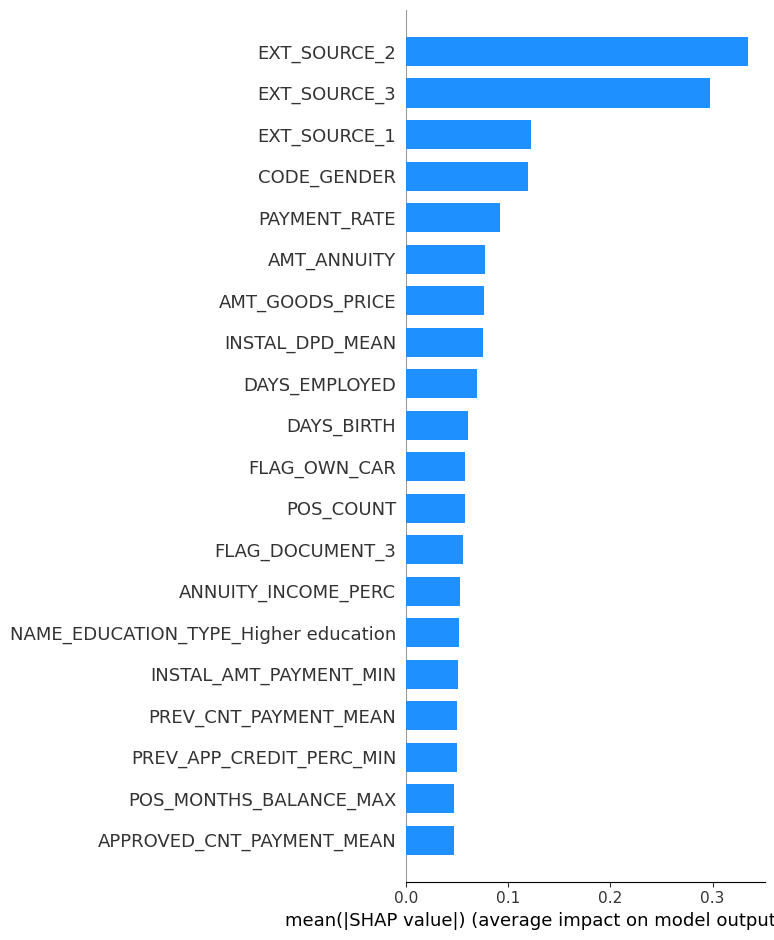

In [85]:
shap.summary_plot(explainer.shap_values(X_test, check_additivity=False),
                  feature_names=X.columns,
                  plot_type="bar",
                  color="dodgerblue"
                  )

### 5.3 - Feature importance locale

**1er échantillon**

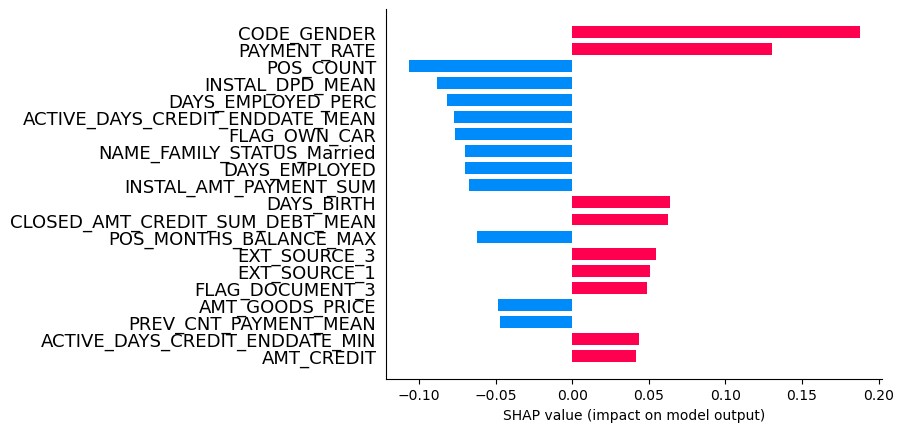

In [137]:
shap.bar_plot(explainer.shap_values(X_test[0]),
              feature_names=X.columns,
              max_display=20)

In [114]:
shap.force_plot(explainer.expected_value,
                explainer.shap_values(X_test[0]),
                feature_names=X.columns,
                out_names="prédiction")

In [91]:
# Associer noms et valeurs
for col, val in zip(X.columns, X_test[0]):
    print(f"{col}: {val}")

SK_ID_CURR: 1.1318700079403567
CNT_CHILDREN: -0.5894217207263497
AMT_INCOME_TOTAL: -0.018928997117881256
AMT_CREDIT: 0.012507108810516263
AMT_ANNUITY: 0.10644971927699
AMT_GOODS_PRICE: -0.12393183274436381
REGION_POPULATION_RELATIVE: -0.15851381330933634
DAYS_BIRTH: 0.3058822964573959
DAYS_EMPLOYED: -0.8160281405069515
DAYS_REGISTRATION: 0.03076522254585561
DAYS_ID_PUBLISH: -1.1646748765134527
FLAG_MOBIL: 0.0
FLAG_EMP_PHONE: 0.4278366793191026
FLAG_WORK_PHONE: -0.5254087773387821
FLAG_CONT_MOBILE: 0.04332005210594774
FLAG_PHONE: -0.5988623920597015
FLAG_EMAIL: -0.2442841261338073
CNT_FAM_MEMBERS: -0.17642728791916854
REGION_RATING_CLIENT: 1.7711005498954453
REGION_RATING_CLIENT_W_CITY: 1.8295815481137208
HOUR_APPR_PROCESS_START: 0.32483087104161257
REG_REGION_NOT_LIVE_REGION: -0.1289433886532155
REG_REGION_NOT_WORK_REGION: -0.2394322970377488
LIVE_REGION_NOT_WORK_REGION: -0.21166304770797895
REG_CITY_NOT_LIVE_CITY: -0.3266159213159415
REG_CITY_NOT_WORK_CITY: -0.6021842759838771
LIVE_CI

**2ème échantillon**

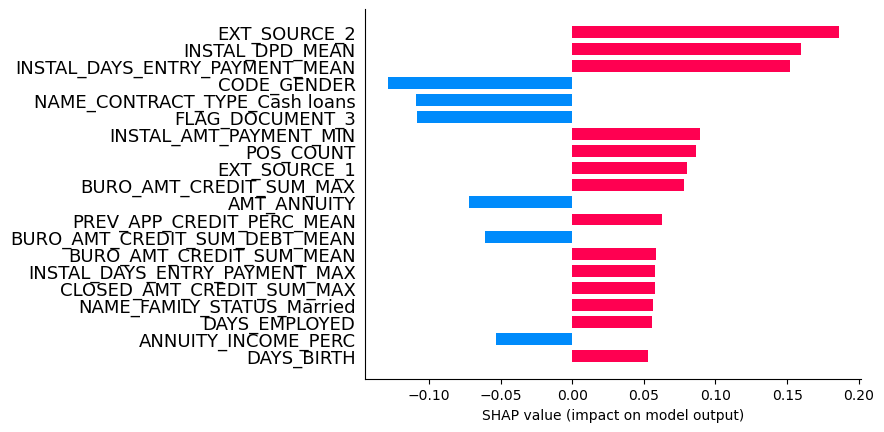

In [131]:
shap.bar_plot(explainer.shap_values(X_test[4]),
              feature_names=X.columns,
              max_display=20)

In [133]:
shap.force_plot(explainer.expected_value,
                explainer.shap_values(X_test[4]),
                feature_names=X.columns,
                out_names="prédiction")

In [135]:
# Associer noms et valeurs
for col, val in zip(X.columns, X_test[4]):
    print(f"{col}: {val}")

SK_ID_CURR: 1.0670527983878042
CNT_CHILDREN: -0.5894217207263497
AMT_INCOME_TOTAL: -0.061153686385259566
AMT_CREDIT: -0.8174076822819716
AMT_ANNUITY: -0.9813107676437793
AMT_GOODS_PRICE: -0.7100738171741511
REGION_POPULATION_RELATIVE: -0.09944360984249102
DAYS_BIRTH: 0.022708350888798176
DAYS_EMPLOYED: 0.6432921349693471
DAYS_REGISTRATION: 0.09933655717322168
DAYS_ID_PUBLISH: 0.5314779966547232
FLAG_MOBIL: 0.0
FLAG_EMP_PHONE: 0.4278366793191026
FLAG_WORK_PHONE: -0.5254087773387821
FLAG_CONT_MOBILE: 0.04332005210594774
FLAG_PHONE: -0.5988623920597015
FLAG_EMAIL: -0.2442841261338073
CNT_FAM_MEMBERS: -1.2516224327806793
REGION_RATING_CLIENT: -0.19055520003894338
REGION_RATING_CLIENT_W_CITY: -0.1542298487818076
HOUR_APPR_PROCESS_START: -0.8963979219326279
REG_REGION_NOT_LIVE_REGION: -0.1289433886532155
REG_REGION_NOT_WORK_REGION: -0.2394322970377488
LIVE_REGION_NOT_WORK_REGION: -0.21166304770797895
REG_CITY_NOT_LIVE_CITY: -0.3266159213159415
REG_CITY_NOT_WORK_CITY: -0.6021842759838771
LIVE

**3ème échantillon**

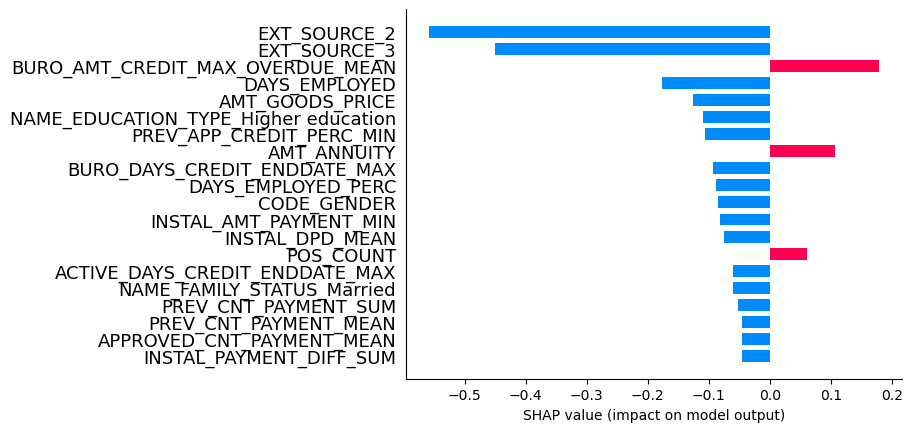

In [129]:
shap.bar_plot(explainer.shap_values(X_test[5]),
              feature_names=X.columns,
              max_display=20)

In [120]:
shap.force_plot(explainer.expected_value,
                explainer.shap_values(X_test[5]),
                feature_names=X.columns,
                out_names="prédiction")

In [122]:
# Associer noms et valeurs
for col, val in zip(X.columns, X_test[5]):
    print(f"{col}: {val}")

SK_ID_CURR: 0.12217509229320615
CNT_CHILDREN: -0.5894217207263497
AMT_INCOME_TOTAL: 0.13307988424468067
AMT_CREDIT: 1.4423624473324037
AMT_ANNUITY: 0.7783408005274408
AMT_GOODS_PRICE: 1.1786059104329412
REGION_POPULATION_RELATIVE: 1.9985433187293153
DAYS_BIRTH: -0.8560755615592341
DAYS_EMPLOYED: -4.691938478788894
DAYS_REGISTRATION: -1.827663842312419
DAYS_ID_PUBLISH: 0.07947759949935593
FLAG_MOBIL: 0.0
FLAG_EMP_PHONE: 0.4278366793191026
FLAG_WORK_PHONE: -0.5254087773387821
FLAG_CONT_MOBILE: 0.04332005210594774
FLAG_PHONE: -0.5988623920597015
FLAG_EMAIL: -0.2442841261338073
CNT_FAM_MEMBERS: -0.17642728791916854
REGION_RATING_CLIENT: -2.152210949973332
REGION_RATING_CLIENT_W_CITY: -2.1380412456773357
HOUR_APPR_PROCESS_START: -0.28578352544550767
REG_REGION_NOT_LIVE_REGION: -0.1289433886532155
REG_REGION_NOT_WORK_REGION: -0.2394322970377488
LIVE_REGION_NOT_WORK_REGION: -0.21166304770797895
REG_CITY_NOT_LIVE_CITY: -0.3266159213159415
REG_CITY_NOT_WORK_CITY: -0.6021842759838771
LIVE_CITY_N